Custom code for gene regulation analyses in: <br>
"Evolution of gene expression across brain regions in behaviorally divergent deer mice" <br><br>
Written by Andi Kautt in 2018/2019 <br><br>
I highly recommend installing https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/ and turning the TOC option on <br><br>

## Load packages

In [1]:
library(biomaRt)
library(WebGestaltR)
library(plotly)
library(data.table)
library(pheatmap)
library(dendsort)
library(cluster)
library(cowplot)
#library(waffle)
library(plyr)
library(tidyverse)
library(scales)
library(ggforce)

******************************************

*                                        *

*          Welcome to WebGestaltR !      *

*                                        *

******************************************

Loading required package: ggplot2

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:biomaRt’:

    select

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘plyr’

The following objects are masked from ‘package:plotly’:

    arrange, mutate, rename, summarise

── Attaching packages ─────────────────

In [2]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Rocky Linux 8.7 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /n/home00/akautt/.conda/envs/work/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggforce_0.2.2     scales_1.0.0      forcats_0.4.0     stringr_1.4.0    
 [5] dplyr_0.8.1       purrr_0.3.2       readr_1.3.1       tidyr_0.8.3      
 [9] tibble_2.1.3      tidyverse_1.2.1   plyr_1.8.4        waffle_0.7.0     
[13] cowplot_1.0.0     cluster_2.0.7-1   dendsort_0.3.3    p

In [3]:
# Overwrite default draw_colnames in pheatmap package
# code found here http://stackoverflow.com/questions/15505607
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)

## Set up workdir and load files

In [110]:
project_path = "/n/hoekstra_lab_tier1/Users/akautt/projects/Peromyscus_RNAseq_brain"

plot_path = file.path(project_path, "results_plots_tables/")

setwd(file.path(project_path, "data/MMDIFF"))

### Load annotation to get info on coding and pseudogenes in Mus

do once and save gene lists as files

In [7]:
# Get Mus annotation from ENSEMBL using biomaRt
# NOTE: parent GO terms are not always assigned - can lead to differences compared to GOrilla, etc.

ensembl <- useMart("ensembl", dataset="mmusculus_gene_ensembl")
annot <- getBM(c("ensembl_gene_id","mgi_symbol","chromosome_name","strand","start_position","end_position",
                     "gene_biotype","external_gene_name","go_id","namespace_1003","name_1006"), mart=ensembl)

listDatasets(ensembl) %>% filter(dataset=="mmusculus_gene_ensembl")

dataset,description,version
mmusculus_gene_ensembl,Mouse genes (GRCm39),GRCm39


In [8]:
annot.simple <- annot %>% select("ontology"=namespace_1003,"GO_ID"=go_id,"term"=name_1006,
                           "ensembl_ID"=ensembl_gene_id,"gene_id"=external_gene_name) %>% mutate_all(na_if,"")
head(annot.simple)

ontology,GO_ID,term,ensembl_ID,gene_id
molecular_function,GO:0030533,triplet codon-amino acid adaptor activity,ENSMUSG00000064336,mt-Tf
biological_process,GO:0006414,translational elongation,ENSMUSG00000064336,mt-Tf
cellular_component,GO:0005739,mitochondrion,ENSMUSG00000064336,mt-Tf
molecular_function,GO:0003735,structural constituent of ribosome,ENSMUSG00000064337,mt-Rnr1
biological_process,GO:0000028,ribosomal small subunit assembly,ENSMUSG00000064337,mt-Rnr1
biological_process,GO:0006412,translation,ENSMUSG00000064337,mt-Rnr1


In [10]:
# list unique biotypes
#annot %>% select(gene_biotype) %>% unique()

In [ ]:
# list of Mus pseudogenes and coding genes

coding <- annot %>% filter(gene_biotype=="protein_coding") %>% 
    select("feature_id"=external_gene_name) %>% unique()

pseudogenes.Mmus <- annot %>% filter(grepl("pseudogene",gene_biotype)) %>% 
    select("feature_id"=external_gene_name) %>% unique()

# write to file
list_path="/n/hoekstra_lab_tier1/Users/akautt/projects/Peromyscus_RNAseq_brain/lists/"

coding_name=paste0(list_path,"mmusculus_gene_ensembl_GRRCm38.p6.coding.genelist.tsv")
pseudogene_name=paste0(list_path,"mmusculus_gene_ensembl_GRRCm38.p6.pseudogenes.genelist.tsv")
if(!file.exists(coding_name)) {
    write_tsv(coding, coding_name)
    write_tsv(pseudogenes.Mmus, pseudogene_name)
}

### Specify files and tissue types

In [5]:
# main data files are output from mmdiff polyomous model selection
mmdiff.output.filelist <- list.files(pattern=".ASE.*.prior_flat0.2.poly.out", recursive=F) %>% 
    lapply(., grep, pattern="control", value=T, invert=T) %>% compact %>% unlist()

mmdiff.output.filelist

tissues = sapply(strsplit(mmdiff.output.filelist,"\\."), `[`, 2)
names(mmdiff.output.filelist) = tissues
tissues

[1] "out_mmdiff.amygdala.ASE.covarSex.prior_flat0.2.poly.out"    
 [2] "out_mmdiff.cerebellum.ASE.covarSex.prior_flat0.2.poly.out"  
 [3] "out_mmdiff.cortex.ASE.covarSex.prior_flat0.2.poly.out"      
 [4] "out_mmdiff.hindbrain.ASE.covarSex.prior_flat0.2.poly.out"   
 [5] "out_mmdiff.hippocampus.ASE.covarSex.prior_flat0.2.poly.out" 
 [6] "out_mmdiff.hypothalamus.ASE.covarSex.prior_flat0.2.poly.out"
 [7] "out_mmdiff.midbrain.ASE.covarSex.prior_flat0.2.poly.out"    
 [8] "out_mmdiff.septum.ASE.covarSex.prior_flat0.2.poly.out"      
 [9] "out_mmdiff.striatum.ASE.covarSex.prior_flat0.2.poly.out"    
[10] "out_mmdiff.thalamus.ASE.covarSex.prior_flat0.2.poly.out"

[1] "amygdala"     "cerebellum"   "cortex"       "hindbrain"    "hippocampus" 
 [6] "hypothalamus" "midbrain"     "septum"       "striatum"     "thalamus"

#### Controls

In [6]:
# control data were generated using a shuffling design (see Supp. Mat. section B in paper)
mmdiff.output.controls.filelist <- list.files(pattern=".ASE.*.prior_flat0.2.poly.out", recursive=F) %>% 
    lapply(., grep, pattern="control", value=T, invert=F) %>% compact %>% unlist()

mmdiff.output.controls.filelist

controls.tissues = sapply(strsplit(mmdiff.output.controls.filelist,"\\."), `[`, 2)
names(mmdiff.output.controls.filelist) = controls.tissues
controls.tissues

[1] "out_mmdiff.amygdala.ASE.covarSex.control.prior_flat0.2.poly.out"    
 [2] "out_mmdiff.cerebellum.ASE.covarSex.control.prior_flat0.2.poly.out"  
 [3] "out_mmdiff.cortex.ASE.covarSex.control.prior_flat0.2.poly.out"      
 [4] "out_mmdiff.hindbrain.ASE.covarSex.control.prior_flat0.2.poly.out"   
 [5] "out_mmdiff.hippocampus.ASE.covarSex.control.prior_flat0.2.poly.out" 
 [6] "out_mmdiff.hypothalamus.ASE.covarSex.control.prior_flat0.2.poly.out"
 [7] "out_mmdiff.midbrain.ASE.covarSex.control.prior_flat0.2.poly.out"    
 [8] "out_mmdiff.septum.ASE.covarSex.control.prior_flat0.2.poly.out"      
 [9] "out_mmdiff.striatum.ASE.covarSex.control.prior_flat0.2.poly.out"    
[10] "out_mmdiff.thalamus.ASE.covarSex.control.prior_flat0.2.poly.out"

[1] "amygdala"     "cerebellum"   "cortex"       "hindbrain"    "hippocampus" 
 [6] "hypothalamus" "midbrain"     "septum"       "striatum"     "thalamus"

#### Gene lists

In [11]:
# genes on  on chrX
chrX_genes <- read.table(file.path(project_path,"lists/Pman_2.1.3_Ppol_1.3.3.gene_name.chrX.genelist.txt"),
                        header=F, fill=T, colClasses=c("character"))
colnames(chrX_genes) <- c("feature_id")

In [12]:
# imprinted genes
impr_genes <- read.table(file.path(project_path,"lists/Pman_2.1.3.imprinted_genes.genelist.txt"),
                        header=T, fill=T, colClasses=c("character"))

In [13]:
# lists of pseudogenes and coding genes - identified by blast to NCBI Pman_1.0 annotation and from Mus ENSEMBL 

pseudogenes.Pman <- read.table(file.path(project_path,"lists/Pman_2.1.3.JC_blast_from_old_NCBI.pseudogenes.genelist.tsv"),
                        header=F, colClasses=c("character"))
colnames(pseudogenes.Pman) <- c("feature_id"); nrow(pseudogenes.Pman)

pseudogenes.Mmus <- read.table(file.path(project_path,"lists/mmusculus_gene_ensembl_GRRCm38.p6.pseudogenes.genelist.tsv"),
                        header=T, colClasses=c("character"))
colnames(pseudogenes.Mmus) <- c("feature_id"); nrow(pseudogenes.Mmus)

pseudogenes <- rbind(pseudogenes.Pman,pseudogenes.Mmus) %>% unique(); nrow(pseudogenes)

coding <- read.table(file.path(project_path,"lists/mmusculus_gene_ensembl_GRRCm38.p6.coding.genelist.tsv"),
                        header=T, colClasses=c("character"))
colnames(coding) <- c("feature_id"); nrow(coding)

[1] 825

[1] 13744

[1] 14235

[1] 21956

### Load data

In [14]:
mmdiff.results <- llply(mmdiff.output.filelist, read.table, header=T, colClasses=c("feature_id"="character"))

llply(mmdiff.results, dim) %>% as.data.frame()

amygdala,cerebellum,cortex,hindbrain,hippocampus,hypothalamus,midbrain,septum,striatum,thalamus
33836,33836,33836,33836,33836,33836,33836,33836,33836,33836
54,54,54,54,54,50,54,54,54,54


In [15]:
# remove genes on chrX

mmdiff.results <- llply(mmdiff.results, anti_join, chrX_genes, by="feature_id")

llply(mmdiff.results, nrow) %>% as.data.frame()

amygdala,cerebellum,cortex,hindbrain,hippocampus,hypothalamus,midbrain,septum,striatum,thalamus
32628,32628,32628,32628,32628,32628,32628,32628,32628,32628


In [16]:
# remove imprinted genes

mmdiff.results <- llply(mmdiff.results, anti_join, impr_genes, by="feature_id")

llply(mmdiff.results, nrow) %>% as.data.frame()

amygdala,cerebellum,cortex,hindbrain,hippocampus,hypothalamus,midbrain,septum,striatum,thalamus
32490,32490,32490,32490,32490,32490,32490,32490,32490,32490


In [17]:
# remove genes with NA or 1 in any post. prob. column (convergence issues)

mmdiff.results <- lapply(mmdiff.results, function(x) {
        x <- x %>% filter_all(all_vars(!is.na(.))) %>% 
            filter(postprob_model0!=1 & postprob_model1!=1 & postprob_model2!=1 & postprob_model3!=1 & postprob_model1!=4)})

llply(mmdiff.results, nrow) %>% as.data.frame()

amygdala,cerebellum,cortex,hindbrain,hippocampus,hypothalamus,midbrain,septum,striatum,thalamus
32488,32475,32487,32469,32476,32484,32485,32486,32479,32476


In [18]:
# remove lowly expressed genes (mu is on ln scale)

mmdiff.results.filter <- lapply(mmdiff.results, function(x) {
        x <- x %>% filter(rowSums(select(.,starts_with("mu_"))>=0)>=3)})

llply(mmdiff.results.filter, nrow) %>% as.data.frame()

amygdala,cerebellum,cortex,hindbrain,hippocampus,hypothalamus,midbrain,septum,striatum,thalamus
13884,13356,13552,13864,13559,14177,13726,13991,13713,13484


In [19]:
# pull out only pseudogenes

mmdiff.results.filter.pseudo <- llply(mmdiff.results.filter, semi_join, pseudogenes, by="feature_id")

llply(mmdiff.results.filter.pseudo, nrow) %>% as.data.frame()

amygdala,cerebellum,cortex,hindbrain,hippocampus,hypothalamus,midbrain,septum,striatum,thalamus
423,433,399,424,429,430,421,432,420,407


In [20]:
# pull out only coding genes

mmdiff.results.filter.coding <- llply(mmdiff.results.filter, semi_join, coding, by="feature_id")

llply(mmdiff.results.filter.coding, nrow) %>% as.data.frame()

amygdala,cerebellum,cortex,hindbrain,hippocampus,hypothalamus,midbrain,septum,striatum,thalamus
12325,11766,12065,12438,12046,12595,12253,12449,12110,12080


In [ ]:
# write filtered data sets to files

sapply(names(mmdiff.results.filter), 
    function (x) write.table(mmdiff.results.filter[[x]], 
        file=paste0("out_mmdiff.",x,".ASE.covarSex.prior_flat0.2.poly.filtered.out"), 
        quote=F, col.names=T, row.names=F, sep="\t"))

#### Controls

In [21]:
mmdiff.controls.results <- llply(mmdiff.output.controls.filelist, read.table, header=T, colClasses=c("feature_id"="character"))

llply(mmdiff.controls.results, dim) %>% as.data.frame()

amygdala,cerebellum,cortex,hindbrain,hippocampus,hypothalamus,midbrain,septum,striatum,thalamus
33836,33836,33836,33836,33836,33836,33836,33836,33836,33836
54,54,54,54,54,50,54,54,54,54


In [22]:
# remove genes on chrX

mmdiff.controls.results <- llply(mmdiff.controls.results, anti_join, chrX_genes, by="feature_id")

llply(mmdiff.controls.results, nrow) %>% as.data.frame()

amygdala,cerebellum,cortex,hindbrain,hippocampus,hypothalamus,midbrain,septum,striatum,thalamus
32628,32628,32628,32628,32628,32628,32628,32628,32628,32628


In [23]:
# remove imprinted genes

mmdiff.controls.results <- llply(mmdiff.controls.results, anti_join, impr_genes, by="feature_id")

llply(mmdiff.controls.results, nrow) %>% as.data.frame()

amygdala,cerebellum,cortex,hindbrain,hippocampus,hypothalamus,midbrain,septum,striatum,thalamus
32490,32490,32490,32490,32490,32490,32490,32490,32490,32490


In [24]:
# remove genes with NA or 1 in any post. prob. column (convergence issues)

mmdiff.controls.results <- lapply(mmdiff.controls.results, function(x) {
        x <- x %>% filter_all(all_vars(!is.na(.))) %>% 
            filter(postprob_model0!=1 & postprob_model1!=1 & postprob_model2!=1 & postprob_model3!=1 & postprob_model1!=4)})

llply(mmdiff.controls.results, nrow) %>% as.data.frame()

amygdala,cerebellum,cortex,hindbrain,hippocampus,hypothalamus,midbrain,septum,striatum,thalamus
32490,32490,32490,32490,32490,32490,32490,32490,32490,32490


In [25]:
# remove lowly expressed genes (mu is on ln scale)

mmdiff.controls.results.filter <- lapply(mmdiff.controls.results, function(x) {
        x <- x %>% filter(rowSums(select(.,matches("mu_"))>=0)>=3)})

llply(mmdiff.controls.results.filter, nrow) %>% as.data.frame()

amygdala,cerebellum,cortex,hindbrain,hippocampus,hypothalamus,midbrain,septum,striatum,thalamus
13886,13371,13555,13885,13573,14183,13731,13995,13724,13497


In [ ]:
# write filtered data sets to files

sapply(names(mmdiff.controls.results.filter), 
    function (x) write.table(mmdiff.controls.results.filter[[x]], 
        file=paste0("out_mmdiff.",x,".ASE.covarSex.prior_flat0.2.poly.filtered.shuffle_control.out"), 
        quote=F, col.names=T, row.names=F, sep="\t"))

### Extract model posteriors

In [26]:
mmdiff.models <- llply(mmdiff.results.filter, select, feature_id,"conserved"=postprob_model0,
        "cis"=postprob_model1,"trans"=postprob_model2,"cis & trans"=postprob_model3,"compensatory"=postprob_model4)

#### Controls

In [29]:
mmdiff.controls.models <- llply(mmdiff.controls.results.filter, select, feature_id,"conserved"=postprob_model0,
        "cis"=postprob_model1,"trans"=postprob_model2,"cis & trans"=postprob_model3,"compensatory"=postprob_model4)

## Bootstrap replicates

Parts of original code written by Jenny Chen - modified to fit general syntax and style here

In [31]:
bs_dir = file.path(project_path,"data/MMDIFF/bootstrapping/")

In [32]:
bs_reps <- sprintf('%0.3d', 1:10)

perc_con.mat <- list(tissues)

for(tissue in c("cerebellum","cortex")){

    for (cur_rep in bs_reps) {
        
        # load bootstrap data
        bs_model.data <- read.table(paste0(bs_dir, "BSrep_", cur_rep, "/out_mmdiff.",tissue,".ASE.covarSex.BSrep_", 
            cur_rep, ".prior_flat0.2.poly.out"), header=T) %>%
            select(feature_id,"bs.conserved"=postprob_model0,"bs.cis"=postprob_model1,"bs.trans"=postprob_model2,
                   "bs.cis & trans"=postprob_model3,"bs.compensatory"=postprob_model4) 
        
        perc_con <- c()
    
        for (thresh in seq(0.5, 0.95, 0.05)) {
            
            # actual data
            model.posteriors <- mmdiff.models[[tissue]] %>% 
            mutate("model"=as.numeric(apply(select(.,-feature_id), 1, function(x){return(which(unlist(x)>thresh))}))) 
        
            # combine with bootstrap data
            suppressWarnings(
            bs_model.posteriors <- bs_model.data %>% right_join(model.posteriors, by="feature_id") %>% 
                mutate("bs.model"=as.numeric(apply(select(.,starts_with("bs.")), 1, function(x){return(which(unlist(x)>thresh))}))))
            
            # concordance
            concordance <- bs_model.posteriors %>% na.omit() %>%
                #replace(., is.na(.), "0") %>% filter(!(model==0 & bs.model==0)) %>% 
                mutate(concordance=if_else(model==bs.model,"match","no match")) %>% group_by(concordance) %>% tally() %>%
                mutate(prop=n/sum(n)) %>% filter(concordance=="match") %>% select(prop) %>% unlist() %>% as.numeric()
            
            perc_con <- c(perc_con, concordance)
                
        }
        perc_con.mat[[tissue]] <- rbind(perc_con.mat[[tissue]],perc_con)
    }   
    colnames(perc_con.mat[[tissue]]) = seq(0.5, 0.95, 0.05)
}

In [36]:
bs.plots <- list()

for(tissue in c("cerebellum","cortex")){

    bs.plots[[tissue]] <- rbind(perc_con.mat[[tissue]] %>% as.data.frame() %>% mutate_all(as.numeric) %>% summarize_all(funs(mean)),
        perc_con.mat[[tissue]] %>% as.data.frame() %>% mutate_all(as.numeric) %>% summarize_all(funs(sd))) %>%
        t() %>% as.data.frame() %>% setNames(c("mean","sd")) %>% rownames_to_column("threshold") %>%
        ggplot( aes(x=threshold, y=mean)) + 
            geom_hline(yintercept=0.95, linetype="dashed", color="gray50", size=1) + 
            geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=0.3, size=0.8) + 
            ylim(0.75,1) +
            labs(title=tissue, y=("Percentage of concordant calls"), x=("Posterior probability threshold")) +
            geom_point(size=4) + 
            theme(plot.title = element_text(color="black", size=14, face="bold",hjust=0.5)) +
            theme(axis.text=element_text(color="black",size=12)) +
            theme(axis.title=element_text(color="black",size=14))
}

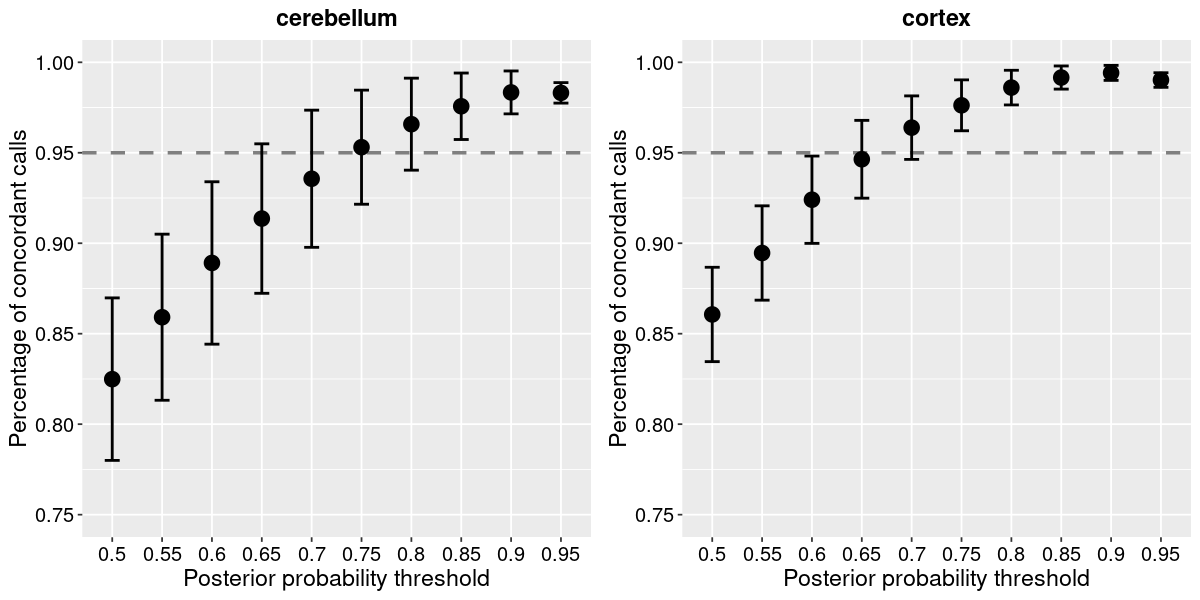

In [37]:
options(repr.plot.height=5,repr.plot.width=10)

plot_grid(plotlist=bs.plots, ncol=2)

file_name=paste0(plot_path,"out_mmdiff.postprob.bootstrap_concordance.pdf")
if(!file.exists(file_name)) {
   ggsave(file_name, width=18, height=6)
}

## Plot posterior probability distributions

Using feature_id as id variables


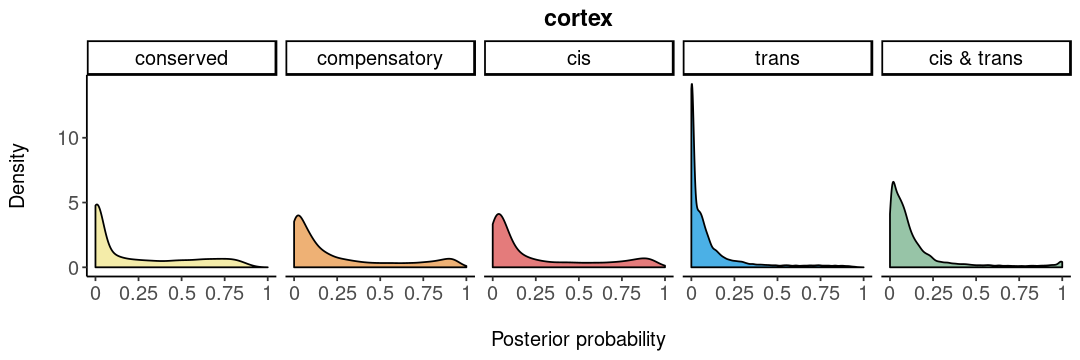

In [38]:
options(repr.plot.width=9, repr.plot.height=3)

#for (tissue in tissues){
tissue="cortex"

    melt(mmdiff.models[[tissue]]) %>% anti_join(pseudogenes,by="feature_id") %>%
    mutate(variable=fct_relevel(variable,"conserved","compensatory","cis","trans","cis & trans")) %>%
    ggplot( aes(x=value, fill=variable)) + geom_density(alpha=0.75) + ggtitle(tissue) +
        xlab("\nPosterior probability") + ylab("Density\n") +
        theme_classic() + facet_wrap(~variable, nrow=1) +
        theme(plot.title = element_text(color="black", size=14, face="bold",hjust=0.5)) +
        scale_fill_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                               'cis & trans'="#74B089")) +
        scale_x_continuous(labels=c(0,0.25,0.5,0.75,1)) + labs(fill="Gene regulatory class") +
        theme(legend.position="none") + #c(0.85, 0.2)) +
        theme(strip.text.x=element_text(size=12, colour="black", angle=0)) +
        theme(axis.title=element_text(size=12), axis.text=element_text(size=12)) + 
        theme(legend.text=element_text(size=12), legend.title=element_text(size=13)) 

    file_name=paste0(plot_path,"out_mmdiff.",tissue,".postprobdist.pdf")
    if(!file.exists(file_name)) {
        ggsave(file_name, width=9, height=3)
    }

#}

### Controls

Using feature_id as id variables


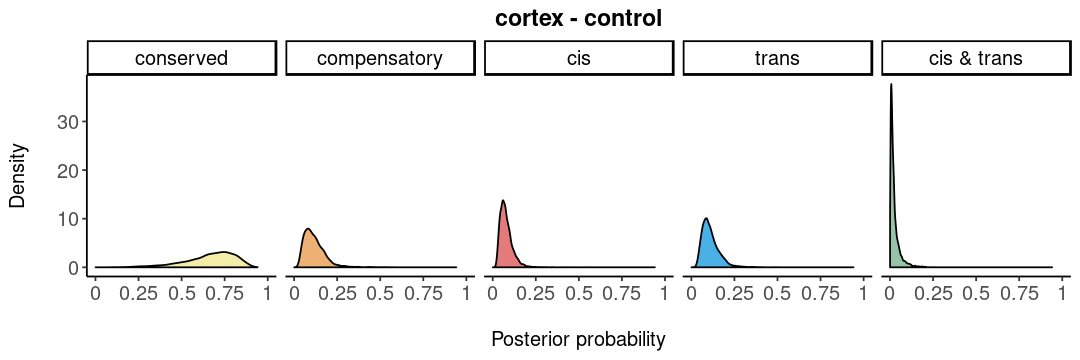

In [39]:
options(repr.plot.width=9, repr.plot.height=3)

#for (tissue in tissues){
tissue="cortex"

    melt(mmdiff.controls.models[[tissue]]) %>% anti_join(pseudogenes,by="feature_id") %>%
    mutate(variable=fct_relevel(variable,"conserved","compensatory","cis","trans","cis & trans")) %>%
    ggplot( aes(x=value, fill=variable)) + geom_density(alpha=0.75) + ggtitle(paste0(tissue," - control")) +
        xlab("\nPosterior probability") + ylab("Density\n") +
        theme_classic() + facet_wrap(~variable, nrow=1) + coord_cartesian(xlim=c(0,1)) +
        theme(plot.title = element_text(color="black", size=14, face="bold",hjust=0.5)) +
        scale_fill_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                               'cis & trans'="#74B089")) +
        scale_x_continuous(labels=c(0,0.25,0.5,0.75,1)) + labs(fill="Gene regulatory class") +
        theme(legend.position="none") + # c(0.85, 0.2)) +
        theme(strip.text.x=element_text(size=12, colour="black", angle=0)) +
        theme(axis.title=element_text(size=12), axis.text=element_text(size=12)) + 
        theme(legend.text=element_text(size=12), legend.title=element_text(size=13)) 
        

    file_name=paste0(plot_path,"out_mmdiff.",tissue,".postprobdist.control.pdf")
    if(!file.exists(file_name)) {
        ggsave(file_name, width=9, height=3)
    }

#}

## Quantify number of genes per category

In [41]:
gene_count <- data.frame(matrix(nrow=(length(tissues)*10),ncol=7))
colnames(gene_count) <- c("tissue","threshold","conserved","cis","trans","cis & trans","compensatory")
i=1

for (tissue in tissues){

    for (threshold in seq(0.5,0.95,0.05)){
        model="conserved"; conserved.count <- filter(mmdiff.models[[tissue]], mmdiff.models[[tissue]][[model]] >= threshold) %>% 
                    anti_join(pseudogenes,by="feature_id") %>% nrow()
        model="cis"; cis.count <- filter(mmdiff.models[[tissue]], mmdiff.models[[tissue]][[model]] >= threshold) %>% 
                    anti_join(pseudogenes,by="feature_id") %>% nrow()
        model="trans"; trans.count <- filter(mmdiff.models[[tissue]], mmdiff.models[[tissue]][[model]] >= threshold) %>% 
                    anti_join(pseudogenes,by="feature_id") %>% nrow()
        model="cis & trans"; cistrans.count <- filter(mmdiff.models[[tissue]], mmdiff.models[[tissue]][[model]] >= threshold) %>% 
                    anti_join(pseudogenes,by="feature_id") %>% nrow()
        model="compensatory"; compensatory.count <- filter(mmdiff.models[[tissue]], mmdiff.models[[tissue]][[model]] >= threshold) %>% 
                    anti_join(pseudogenes,by="feature_id") %>% nrow()
        gene_count[i,1] <- tissue
        gene_count[i,2] <- threshold
        gene_count[i,3] <- conserved.count
        gene_count[i,4] <- cis.count
        gene_count[i,5] <- trans.count
        gene_count[i,6] <- cistrans.count
        gene_count[i,7] <- compensatory.count
        i=i+1
    }
}

gene_count %>% head()

tissue,threshold,conserved,cis,trans,cis & trans,compensatory
amygdala,0.50,3429,2848,664,934,2690
amygdala,0.55,3019,2624,557,836,2457
amygdala,0.60,2608,2402,460,754,2248
amygdala,0.65,2159,2143,364,677,2057
amygdala,0.70,1694,1877,279,607,1833
amygdala,0.75,1178,1618,206,562,1592


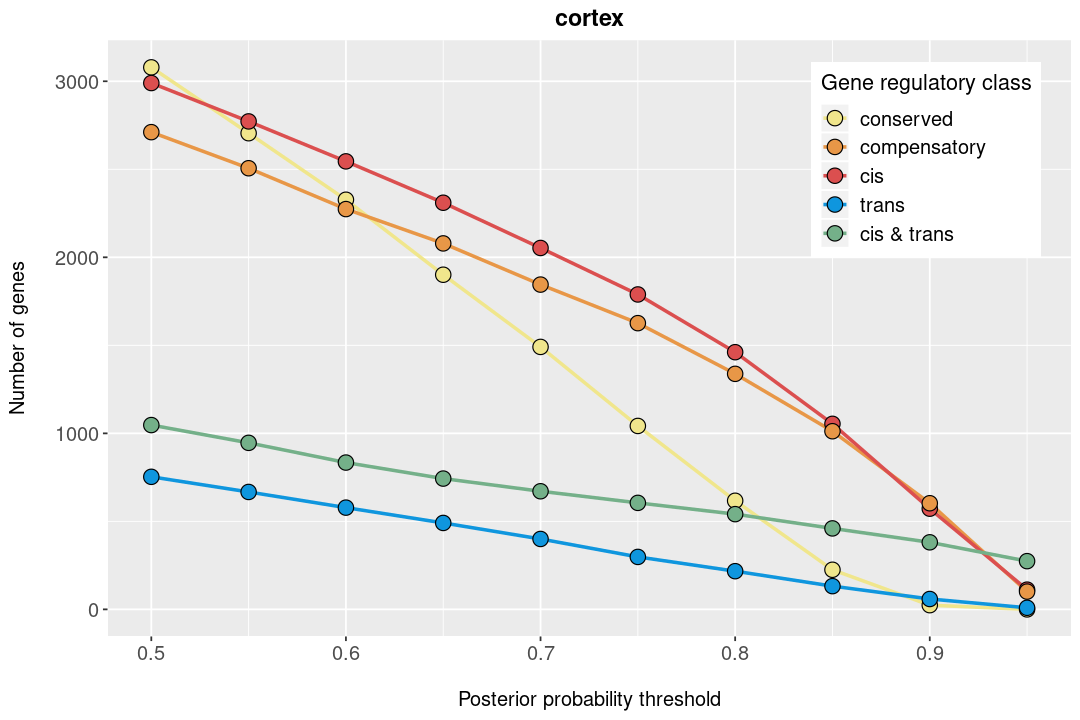

In [42]:
options(repr.plot.width=9, repr.plot.height=6)

#for (tissue in tissues){
tissue="cortex"

    gene_count[gene_count$tissue==tissue,] %>% 
    gather("model","value",conserved,cis,trans,"cis & trans",compensatory, convert=T) %>%
    mutate(class=fct_relevel(model,"conserved","compensatory","cis","trans","cis & trans")) %>%
    ggplot( aes(x=threshold, y=value)) + geom_line(aes(color=class), size=1, alpha=1) + 
        labs(title=tissue, y="Number of genes\n", x="\nPosterior probability threshold") + #theme_dark() +
        theme(plot.title=element_text(color="black", size=14, face="bold", hjust=0.5)) +
        geom_point(aes(fill=class), pch=21, size=4, alpha=1) +
        scale_color_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                               'cis & trans'="#74B089")) +
        scale_fill_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                               'cis & trans'="#74B089")) +
        labs(color="Gene regulatory class", linetype="Gene regulatory class", fill="Gene regulatory class") +
        theme(axis.title=element_text(size=12), axis.text=element_text(size=12)) + 
        theme(legend.position = c(0.85, 0.8)) +
        theme(legend.text=element_text(size=12), legend.title=element_text(size=13)) 
        
    
    file_name=paste0(plot_path,"out_mmdiff.",tissue,".genes_per_postprobthresh.abs.pdf")
    if(!file.exists(file_name)) {
        ggsave(file_name, width=9, height=6)
    }

#}

### Relative counts

In [43]:
gene_count <- gene_count %>% replace(is.na(.), 0) %>% 
    mutate(sum = rowSums(.[3:7])) %>%
    mutate(cons_rel = conserved/sum) %>% 
    mutate(comp_rel = compensatory/sum) %>%
    mutate(cis_rel = cis/sum) %>%
    mutate(trans_rel = trans/sum) %>%
    mutate(cistrans_rel = `cis & trans`/sum)

In [44]:
gene_count %>% filter(threshold==0.75)

tissue,threshold,conserved,cis,trans,cis & trans,compensatory,sum,cons_rel,comp_rel,cis_rel,trans_rel,cistrans_rel
amygdala,0.75,1178,1618,206,562,1592,5156,0.2284717,0.3087665,0.3138092,0.03995345,0.1089992
cerebellum,0.75,899,2096,450,1157,1734,6336,0.1418876,0.2736742,0.3308081,0.07102273,0.1826073
cortex,0.75,1042,1789,298,605,1626,5360,0.1944030,0.3033582,0.3337687,0.05559701,0.1128731
hindbrain,0.75,1086,2002,344,1016,1949,6397,0.1697671,0.3046741,0.3129592,0.05377521,0.1588244
hippocampus,0.75,1029,2013,380,970,1765,6157,0.1671268,0.2866656,0.3269449,0.06171837,0.1575443
hypothalamus,0.75,1200,1897,297,797,1651,5842,0.2054091,0.2826087,0.3247176,0.05083875,0.1364259
midbrain,0.75,1083,1962,390,1000,1890,6325,0.1712253,0.2988142,0.3101976,0.06166008,0.1581028
septum,0.75,1139,1669,254,591,1617,5270,0.2161290,0.3068311,0.3166983,0.04819734,0.1121442
striatum,0.75,947,2126,370,889,1694,6026,0.1571523,0.2811152,0.3528045,0.06140060,0.1475274
thalamus,0.75,1037,2046,409,1006,1724,6222,0.1666667,0.2770813,0.3288332,0.06573449,0.1616843


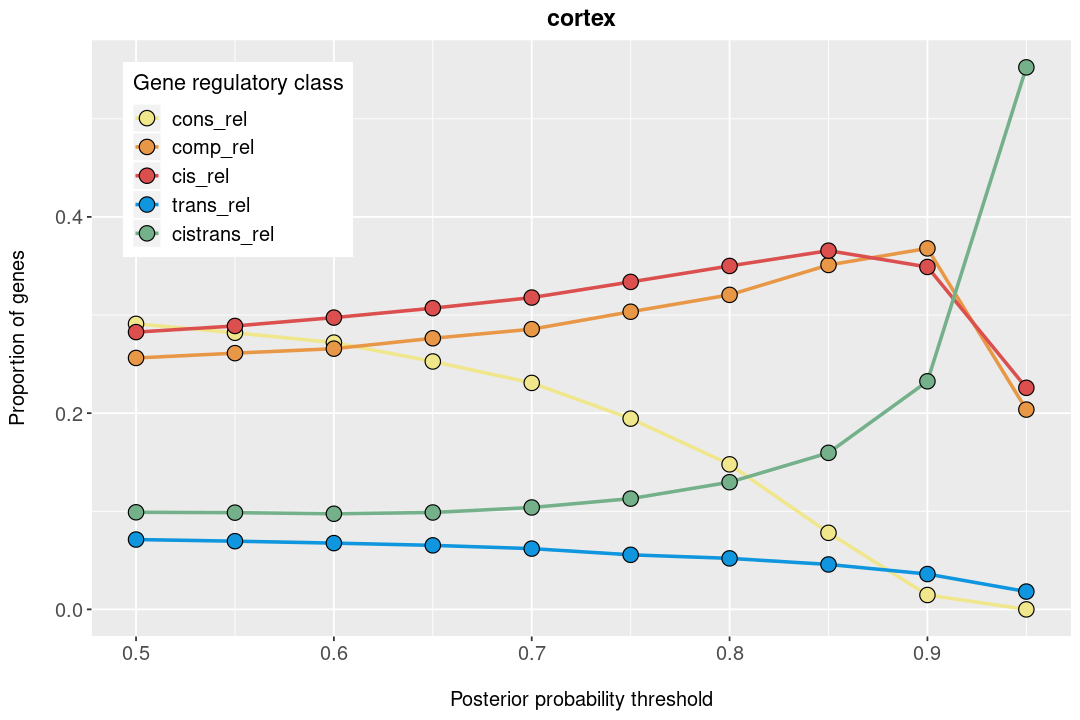

In [45]:
options(repr.plot.width=9, repr.plot.height=6)

#for (tissue in tissues){
tissue="cortex"
    
    gene_count[gene_count$tissue==tissue,] %>% 
    gather("model","value","cons_rel","comp_rel","cis_rel","trans_rel","cistrans_rel", convert=T) %>%
    mutate(class=fct_relevel(model,"cons_rel","comp_rel","cis_rel","trans_rel","cistrans_rel")) %>%
    ggplot( aes(x=threshold, y=value, group=class)) + geom_line(aes(color=class), size=1) + 
        labs(title=tissue, y="Proportion of genes\n", x="\nPosterior probability threshold") + #theme_dark() +
        theme(plot.title=element_text(color="black", size=14, face="bold", hjust=0.5)) +
        geom_point(aes(fill=class), pch=21, size=4) +
        scale_color_manual(values=c(cons_rel="khaki",comp_rel="#E89747",cis_rel="#DB4F4F",trans_rel="#0F96DE",
                               cistrans_rel="#74B089")) +
        scale_fill_manual(values=c(cons_rel="khaki",comp_rel="#E89747",cis_rel="#DB4F4F",trans_rel="#0F96DE",
                               cistrans_rel="#74B089")) +
        labs(color="Gene regulatory class", linetype="Gene regulatory class", fill="Gene regulatory class") +
        theme(axis.title=element_text(size=12), axis.text=element_text(size=12)) + 
        theme(legend.position = c(0.15, 0.8)) +
        theme(legend.text=element_text(size=12), legend.title=element_text(size=13)) 
    
    file_name=paste0(plot_path,"out_mmdiff.",tissue,".genes_per_postprobthresh.rel.pdf")
    if(!file.exists(file_name)) {
        ggsave(file_name, width=9, height=6)
    }
#}

### Controls

In [50]:
controls.gene_count <- data.frame(matrix(nrow=(length(controls.tissues)*10),ncol=7))
colnames(controls.gene_count) <- c("tissue","threshold","conserved","cis","trans","cis & trans","compensatory")
i=1

for (tissue in controls.tissues){

    for (threshold in seq(0.5,0.95,0.05)){
        model="conserved"; conserved.count <- filter(mmdiff.controls.models[[tissue]], mmdiff.controls.models[[tissue]][[model]] >= threshold) %>% 
                    anti_join(pseudogenes,by="feature_id") %>% nrow()
        model="cis"; cis.count <- filter(mmdiff.controls.models[[tissue]], mmdiff.controls.models[[tissue]][[model]] >= threshold) %>% 
                    anti_join(pseudogenes,by="feature_id") %>% nrow()
        model="trans"; trans.count <- filter(mmdiff.controls.models[[tissue]], mmdiff.controls.models[[tissue]][[model]] >= threshold) %>% 
                    anti_join(pseudogenes,by="feature_id") %>% nrow()
        model="cis & trans"; cistrans.count <- filter(mmdiff.controls.models[[tissue]], mmdiff.controls.models[[tissue]][[model]] >= threshold) %>% 
                    anti_join(pseudogenes,by="feature_id") %>% nrow()
        model="compensatory"; compensatory.count <- filter(mmdiff.controls.models[[tissue]], mmdiff.controls.models[[tissue]][[model]] >= threshold) %>% 
                    anti_join(pseudogenes,by="feature_id") %>% nrow()
        controls.gene_count[i,1] <- tissue
        controls.gene_count[i,2] <- threshold
        controls.gene_count[i,3] <- conserved.count
        controls.gene_count[i,4] <- cis.count
        controls.gene_count[i,5] <- trans.count
        controls.gene_count[i,6] <- cistrans.count
        controls.gene_count[i,7] <- compensatory.count
        i=i+1
    }
}

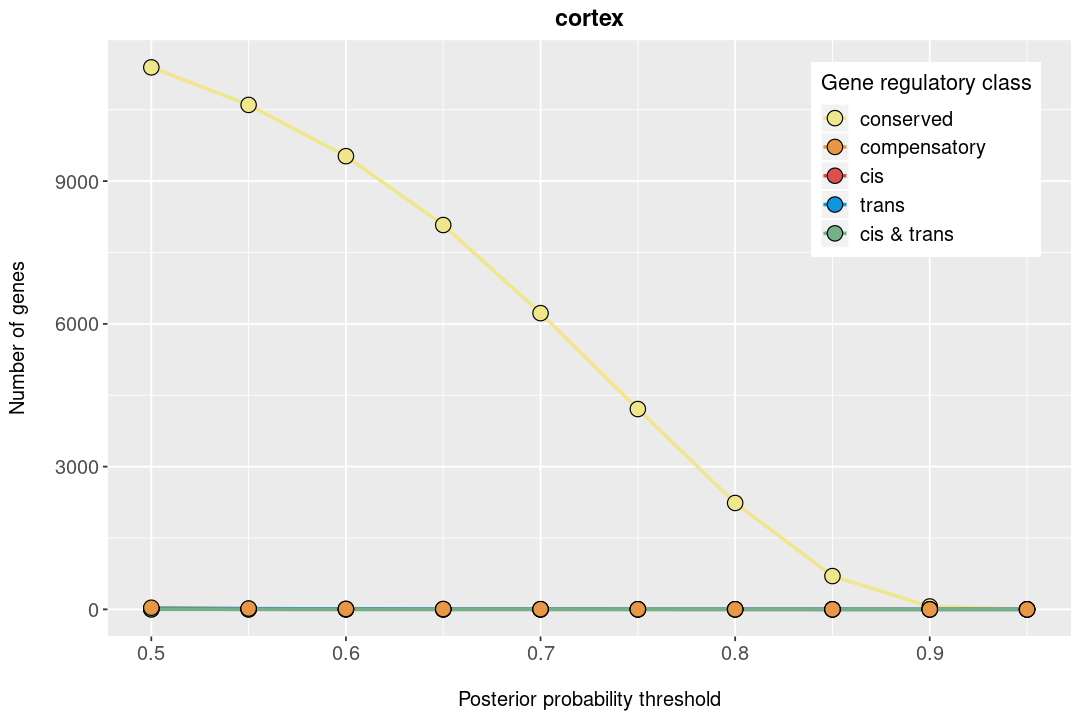

In [51]:
options(repr.plot.width=9, repr.plot.height=6)

#for (tissue in tissues){
tissue="cortex"

    controls.gene_count[controls.gene_count$tissue==tissue,] %>% 
    gather("model","value",conserved,cis,trans,"cis & trans",compensatory, convert=T) %>%
    mutate(class=fct_relevel(model,"conserved","compensatory","cis","trans","cis & trans")) %>%
    ggplot( aes(x=threshold, y=value)) + geom_line(aes(color=class), size=1, alpha=1) + 
        labs(title=tissue, y="Number of genes\n", x="\nPosterior probability threshold") + #theme_dark() +
        theme(plot.title=element_text(color="black", size=14, face="bold", hjust=0.5)) +
        geom_point(aes(fill=class), pch=21, size=4, alpha=1) +
        scale_color_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                               'cis & trans'="#74B089")) +
        scale_fill_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                               'cis & trans'="#74B089")) +
        labs(color="Gene regulatory class", linetype="Gene regulatory class", fill="Gene regulatory class") +
        theme(axis.title=element_text(size=12), axis.text=element_text(size=12)) + 
        theme(legend.position = c(0.85, 0.8)) +
        theme(legend.text=element_text(size=12), legend.title=element_text(size=13)) 
        
    
    file_name=paste0(plot_path,"out_mmdiff.",tissue,".controls.genes_per_postprobthresh.abs.pdf")
    if(!file.exists(file_name)) {
        ggsave(file_name, width=9, height=6)
    }

#}

## Scatterplot of genes according to regulatory class

In [52]:
# set posterior probability threshold for assigning genes to regulatory classes

thresh=0.75

In [53]:
# calculate weighted log fold change following Shen et al. 2014 - https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0109382

mmdiff.results.filter.classes.weighted <- lapply(mmdiff.results.filter, function(x) {
    x <- left_join(x %>% select(feature_id,contains("mu_")) %>% gather(ID,mu,-feature_id) %>%
          mutate(ID=str_replace(ID,"mu_","")),
          x %>% select(feature_id,contains("sd_")) %>% gather(ID,sd,-feature_id) %>%
          mutate(ID=str_replace(ID,"sd_","")), 
             by=c("feature_id","ID")) %>% 
    mutate("group"=case_when(str_detect(ID,"BW_") ~ "BW",
                                  str_detect(ID,"PO_") ~ "PO",
                                     str_detect(ID,"F1_") & str_detect(ID,".BW") ~ "F1.BW",
                                        str_detect(ID,"F1_") & str_detect(ID,".PO") ~ "F1.PO")) %>% 
    mutate("num"=(mu/sd^2), "denom"=(1/sd^2)) %>% 
    group_by(feature_id,group) %>% summarise(value=sum(num)/sum(denom)) %>% spread(group,value) %>% 
    transmute("ratio.par"=(BW-PO)/log(2),
                "ratio.F1s"=(F1.BW-F1.PO)/log(2)) %>% 
    left_join(x %>% mutate("base.expr"=rowMeans(exp(select(.,starts_with("mu_"))))) %>% 
              select(feature_id, base.expr, contains("postprob_")),by="feature_id") %>% 
    rename(cons=postprob_model0,cis=postprob_model1,trans=postprob_model2,
           cis_trans=postprob_model3,comp=postprob_model4) %>%
    mutate("class"=if_else(cons >= thresh, "conserved",
                            if_else(cis >= thresh, "cis",
                                if_else(trans >= thresh, "trans",
                                    if_else(cis_trans >= thresh, "cis & trans", 
                                            if_else(comp >= thresh, "compensatory","unassigned")))))) %>% 
    mutate(ratio=ratio.par/ratio.F1s) %>% as.data.frame() %>%
    mutate(class_new=if_else(class=="cis & trans" & ratio > 1,"cis + trans",
                              if_else(class=="cis & trans" & ratio < 1,"cis x trans",class))) %>%
    mutate(class_new=fct_relevel(class_new,"unassigned","conserved","compensatory","cis","trans","cis + trans","cis x trans"))
})

In [54]:
# combine all subregions results

mmdiff.results.filter.classes.weighted.all <- do.call(rbind, mmdiff.results.filter.classes.weighted) %>% 
    rownames_to_column("subregion") %>% mutate(subregion=str_replace(subregion,"\\.\\d+",""))

In [55]:
# how many unique genes do we have in total?
mmdiff.results.filter.classes.weighted.all %>% anti_join(pseudogenes, by="feature_id") %>% select(feature_id) %>% unlist() %>% unique() %>% length()

[1] 15308

In [58]:
# total number of data points (genes across subregions that could be assigned)
mmdiff.results.filter.classes.weighted.all %>%
    anti_join(pseudogenes, by="feature_id") %>% 
    filter(class_new!="unassigned") %>% nrow()

[1] 59091

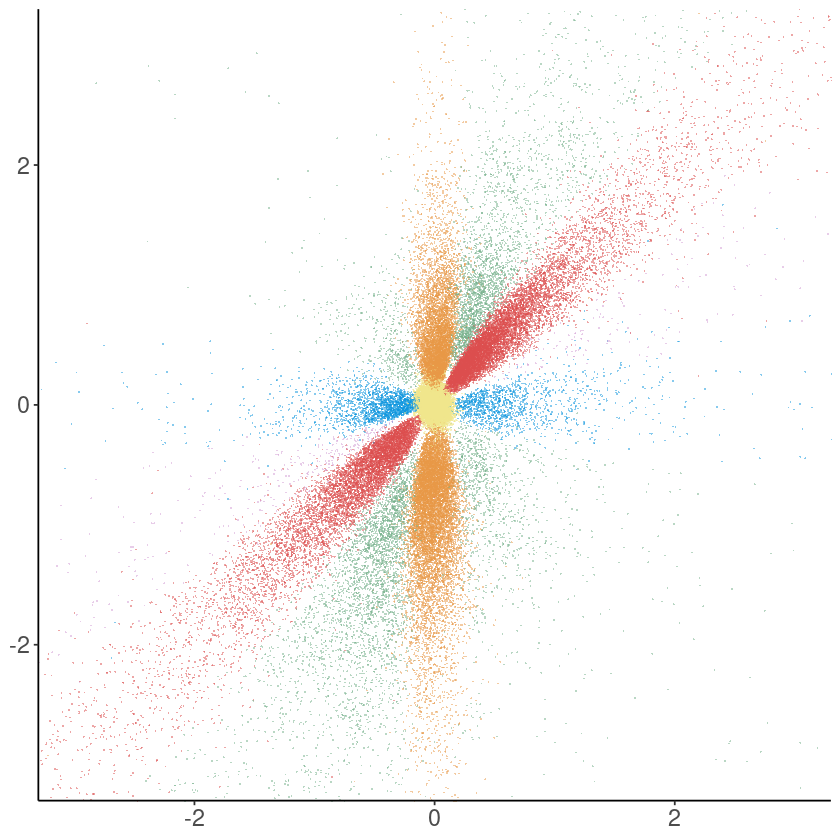

In [59]:
options(repr.plot.width=7, repr.plot.height=7)

# scatterplot of weighted log2 fold changes of parental species versus alleles in F1 hybrid
# NOTE the coord_cartesian or facet_zoom call to zoom in 

mmdiff.results.filter.classes.weighted.all %>%
    anti_join(pseudogenes, by="feature_id") %>% 
    filter(class_new!="unassigned") %>%
    ggplot( aes(ratio.par, ratio.F1s, fill=class_new)) + 
        #geom_bin2d(binwidth=0.015, alpha=0.75) + 
        geom_point(size=0.5, alpha=0.5, stroke=0.01, pch=21) +
        xlab("\nweighted log2 (P. maniculatus / P. polionotus) - parental species") + 
        ylab("weighted log2 (P. maniculatus / P. polionotus) - alleles in F1 hybrids\n") + 
        #labs(title=paste0("All subregions\n")) + 
        scale_fill_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                                   'cis x trans'="#74B089",'cis + trans'="#D19CD3")) +
        theme_classic() + #theme(legend.position = "none") +
        theme(axis.text=element_text(size=14), axis.title=element_text(size=14)) + labs(fill="Gene regulatory class") +
        theme(legend.text=element_text(size=12, color="black"), legend.title=element_text(size=13)) +
        theme(plot.title=element_blank(), axis.title=element_blank()) + 
        #theme(plot.title=element_text(color="black", size=16, face="bold", hjust=0.5)) +
        theme(legend.position="none") + #=c(0.1, 0.85)) + 
        coord_cartesian(ylim=c(-3,3), xlim=c(-3,3))
        #facet_zoom(ylim=c(-3,3), xlim=c(-3,3))

        #file_name=paste0(plot_path,"out_mmdiff.all_subregions.scatterplot_classes.posterior",thresh,".png")
        #if(!file.exists(file_name)) {
        #    ggsave(file_name, width=7, height=7)
        #}

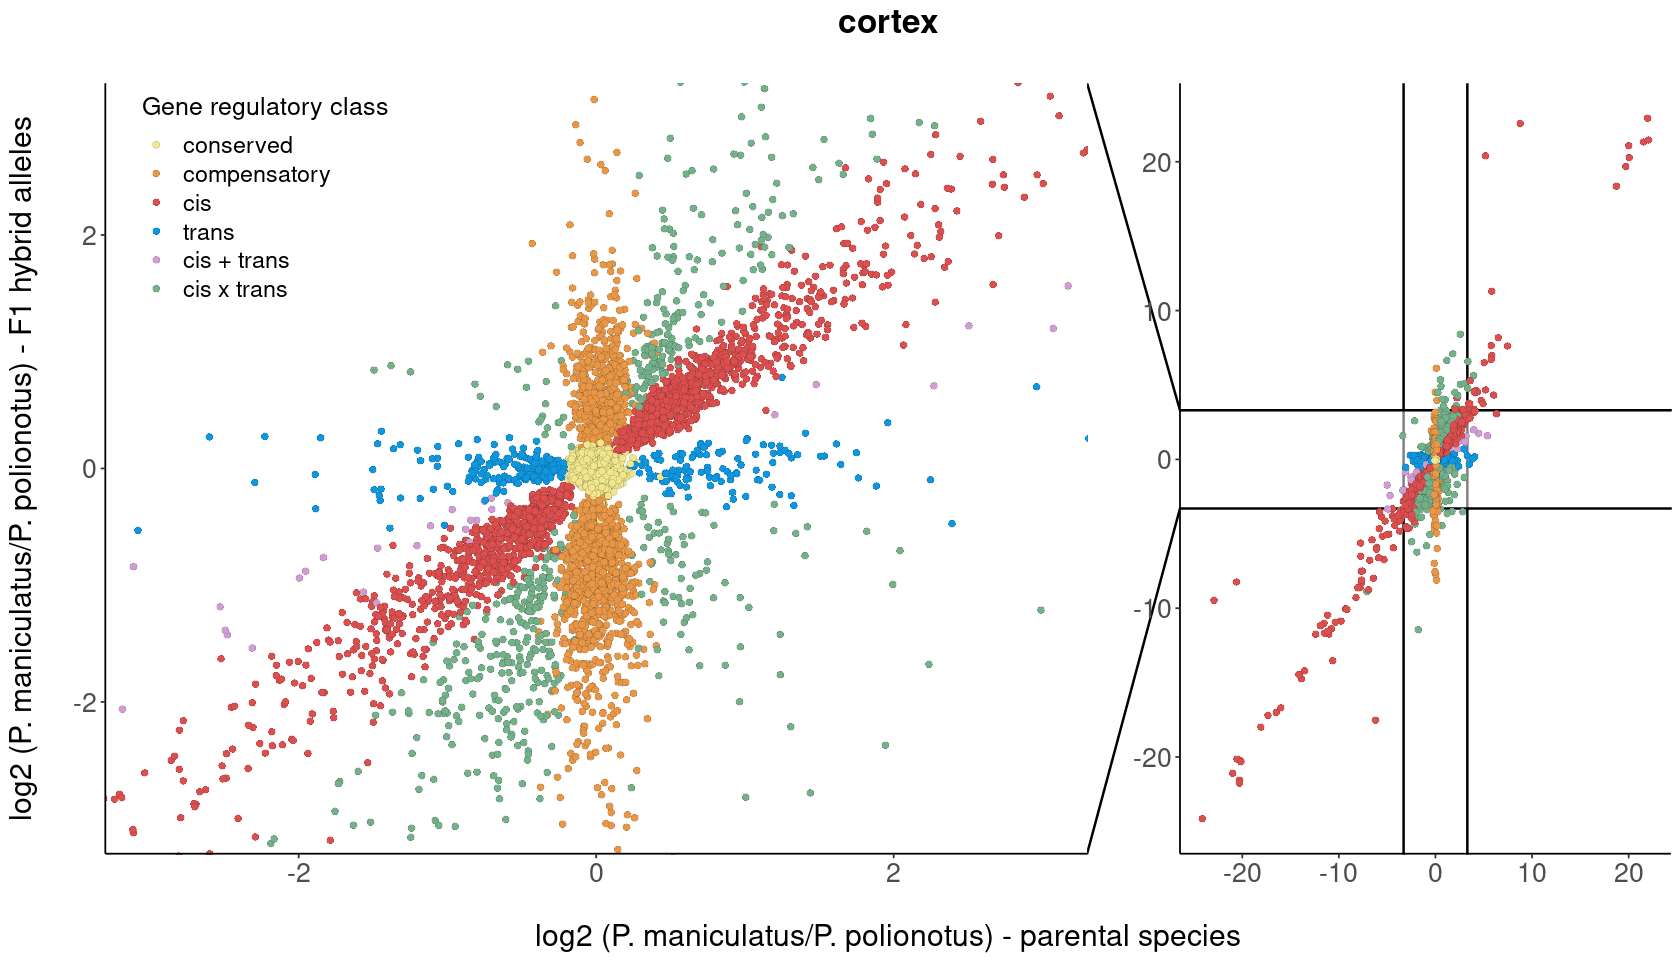

In [61]:
options(repr.plot.width=14, repr.plot.height=8)

#for(tissue in tissues){
tissue="cortex"

    mmdiff.results.filter.classes.weighted.all %>%
        filter(subregion==tissue) %>% 
        anti_join(pseudogenes, by="feature_id") %>% 
        filter(class_new!="unassigned") %>%
        ggplot( aes(ratio.par, ratio.F1s, fill=class_new)) + 
            #geom_bin2d(binwidth=0.05, alpha=0.8) + coord_cartesian(xlim=c(-3,3),ylim=c(-3,3)) + theme_classic()
            geom_point(size=2.0, stroke=0.05, pch=21) +
            xlab("\nlog2 (P. maniculatus/P. polionotus) - parental species") + 
            ylab("log2 (P. maniculatus/P. polionotus) - F1 hybrid alleles\n") + 
            labs(title=paste0(tissue,"\n")) + 
            scale_fill_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                                       'cis x trans'="#74B089",'cis + trans'="#D19CD3")) +
            theme_classic() + #theme(legend.position = "none") +
            theme(axis.text=element_text(size=16), axis.title=element_text(size=18)) + labs(fill="Gene regulatory class") +
            theme(legend.text=element_text(size=14), legend.title=element_text(size=15)) +
            theme(plot.title=element_text(color="black", size=20, face="bold", hjust=0.5)) +
            theme(legend.position=c(0.1, 0.85)) + 
            facet_zoom(ylim=c(-3,3), xlim=c(-3,3))
        
            #file_name=paste0(plot_path,"out_mmdiff.",tissue,".scatterplot_classes.posterior",thresh,".pdf")
            #if(!file.exists(file_name)) {
            #    ggsave(file_name, width=14, height=8)
            #}
#}

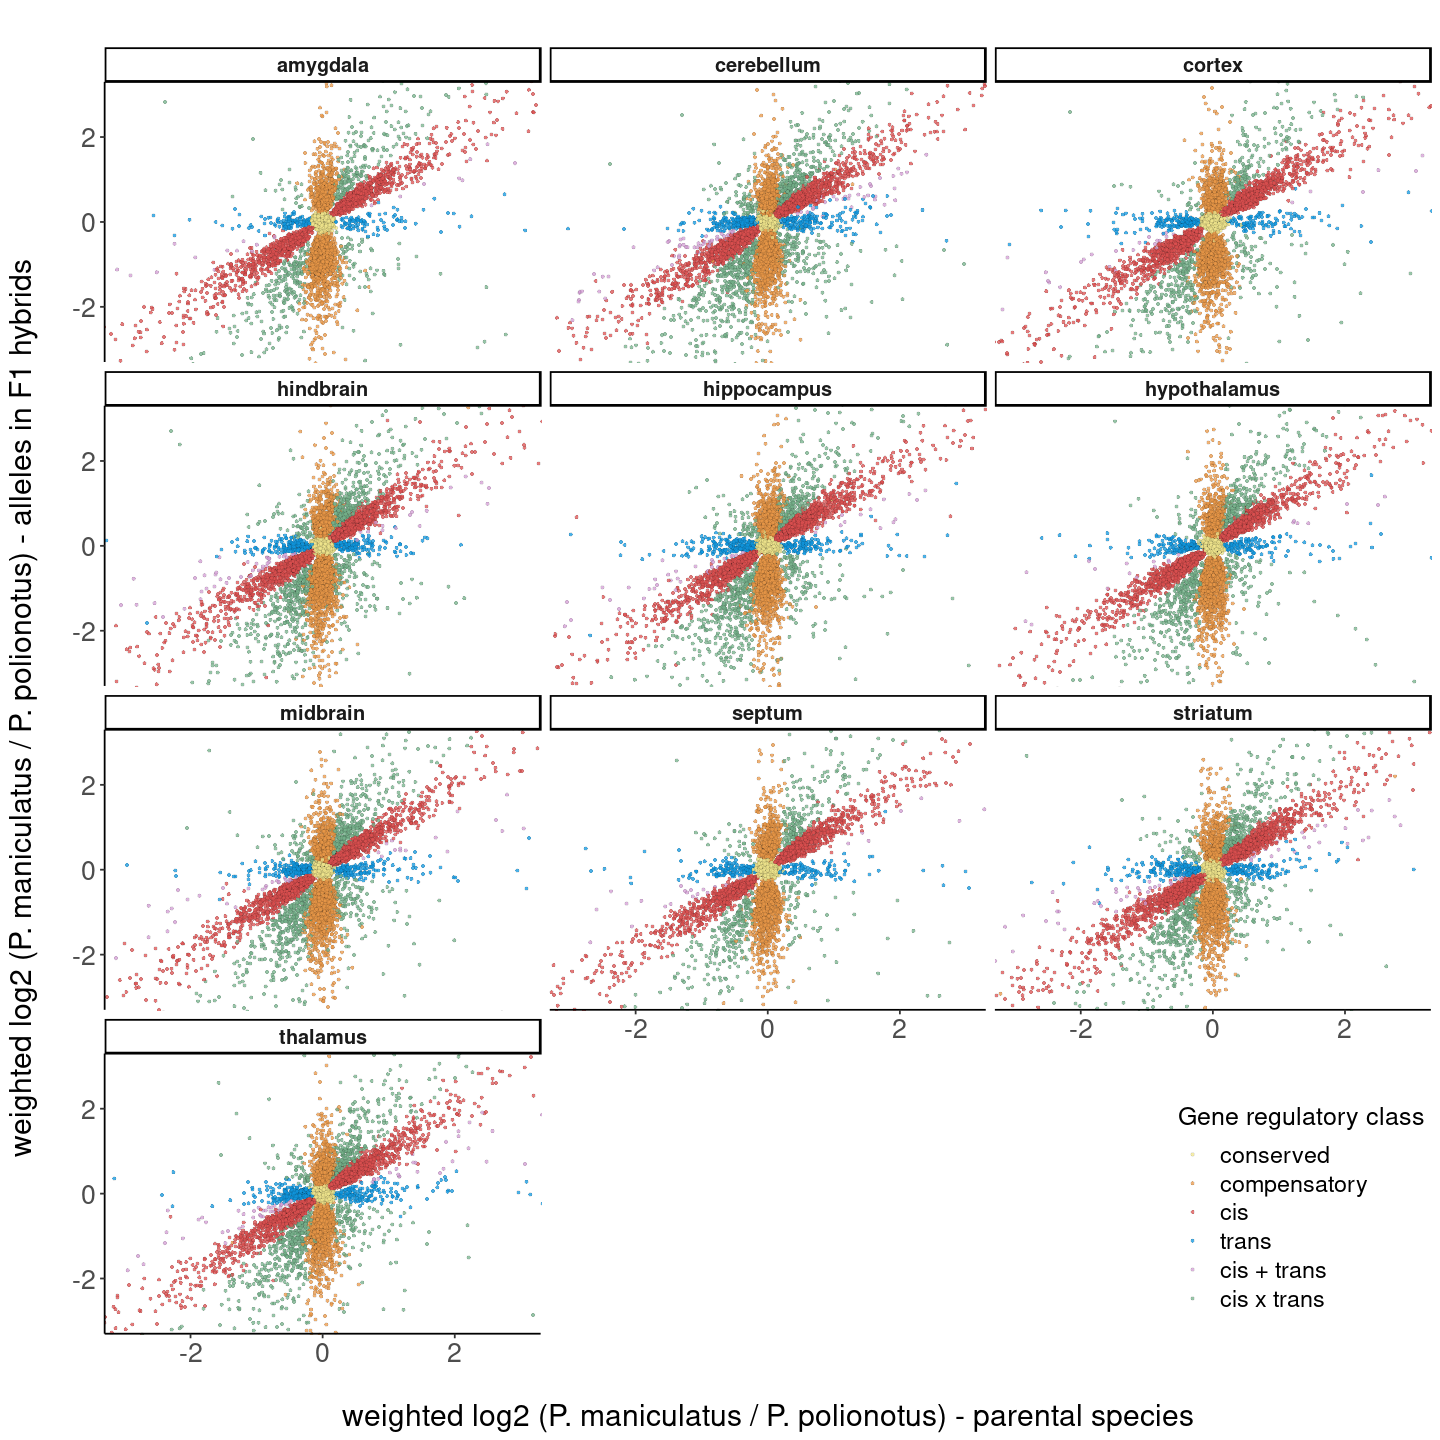

In [62]:
options(repr.plot.width=12, repr.plot.height=12)

mmdiff.results.filter.classes.weighted.all %>% 
    anti_join(pseudogenes, by="feature_id") %>% 
    filter(class_new!="unassigned") %>%
    ggplot( aes(ratio.par, ratio.F1s, fill=class_new)) + 
        #geom_bin2d(binwidth=0.05, alpha=0.8) + coord_cartesian(xlim=c(-3,3),ylim=c(-3,3)) + theme_classic()
        geom_point(size=1.0, alpha=0.75, stroke=0.05, pch=21) +
        xlab("\nweighted log2 (P. maniculatus / P. polionotus) - parental species") + 
        ylab("weighted log2 (P. maniculatus / P. polionotus) - alleles in F1 hybrids\n") + 
        labs(title="") + 
        scale_fill_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                                   'cis x trans'="#74B089",'cis + trans'="#D19CD3")) +
        theme_classic() + #theme(legend.position = "none") +
        theme(axis.text=element_text(size=16), axis.title=element_text(size=18)) + labs(fill="Gene regulatory class") +
        theme(legend.text=element_text(size=14), legend.title=element_text(size=15)) +
        theme(plot.title=element_text(color="black", size=20, face="bold", hjust=0.5)) +
        theme(legend.position=c(0.9, 0.1)) + theme(strip.text = element_text(size=12,face="bold")) +
        coord_cartesian(ylim=c(-3,3), xlim=c(-3,3)) +
        facet_wrap(~subregion, nrow=4, ncol=3)
    
        #file_name=paste0(plot_path,"out_mmdiff.all_subregions.scatterplot_classes.facet_by_SR.posterior",thresh,".png")
        #if(!file.exists(file_name)) {
        #    ggsave(file_name, width=10, height=10)
        #}

### LFC distribution by regulatory class

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 1864 rows containing non-finite values (stat_density).”

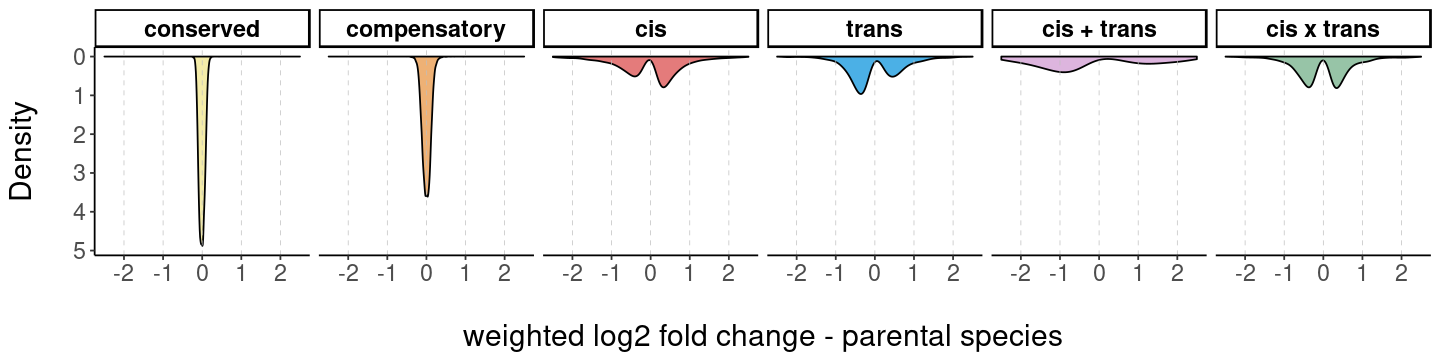

In [64]:
options(repr.plot.width=12, repr.plot.height=3)

mmdiff.results.filter.classes.weighted.all %>% 
anti_join(pseudogenes, by="feature_id") %>% 
    filter(class_new!="unassigned") %>%
    ggplot( aes(x=ratio.par, fill=class_new)) + geom_density(alpha=0.75) + #ggtitle("All subregions\n") +
        xlab("\nweighted log2 fold change - parental species") + ylab("Density\n") +
        theme_classic() + facet_grid(cols=vars(class_new)) + 
        xlim(-2.5,2.5) + ylim(0,5) +
        geom_vline(xintercept=c(-2,-1,0,1,2), col="gray", linetype="dashed", size=0.2) + 
        theme(plot.title = element_text(color="black", size=14, face="bold",hjust=0.5)) + #coord_flip() +
        scale_fill_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                           'cis x trans'="#74B089",'cis + trans'="#D19CD3",unassigned="gray")) +
        theme(axis.text=element_text(size=14), axis.title=element_text(size=18)) + 
        labs(fill="Gene regulatory class") +
        theme(plot.title=element_text(color="black", size=20, face="bold", hjust=0.5)) +
        theme(strip.text=element_text(size=14, colour="black", angle=0, face="bold")) +
        #theme(strip.text=element_blank()) +
        theme(legend.text=element_text(size=14), legend.title=element_text(size=15)) +
        theme(legend.position="none") + scale_y_reverse()

        #file_name=paste0(plot_path,"out_mmdiff.all_subregions.weightedLFC_by_class.parentals.posterior",thresh,".pdf")
        #if(!file.exists(file_name)) {
        #    ggsave(file_name, width=12, height=3)
        #}

Warning message:
“Removed 3082 rows containing non-finite values (stat_density).”

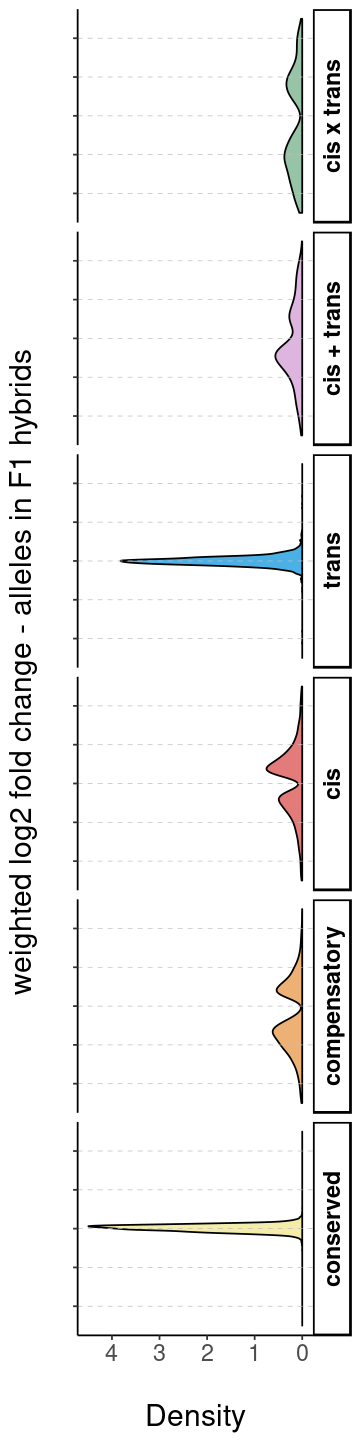

In [66]:
options(repr.plot.width=3, repr.plot.height=12)

mmdiff.results.filter.classes.weighted.all %>% 
    mutate(class_new=fct_relevel(class_new,"cis x trans","cis + trans","trans","cis","compensatory","conserved")) %>%
    anti_join(pseudogenes, by="feature_id") %>% 
    filter(class_new!="unassigned") %>%
    ggplot( aes(x=ratio.F1s, fill=class_new)) + 
        geom_density(alpha=0.75) + #ggtitle("All subregions\n") +
        xlab("weighted log2 fold change - alleles in F1 hybrids\n") + ylab("\nDensity") +
        theme_classic() + facet_grid(rows=vars(class_new)) + 
        xlim(-2.5,2.5) + #ylim(0,5) +
        geom_vline(xintercept=c(-2,-1,0,1,2), col="gray", linetype="dashed", size=0.2) + 
        theme(plot.title = element_text(color="black", size=14, face="bold",hjust=0.5)) + coord_flip() +
        scale_fill_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                           'cis x trans'="#74B089",'cis + trans'="#D19CD3",unassigned="gray")) +
        theme(axis.text=element_text(size=14), axis.title=element_text(size=18)) + 
        theme(axis.text.y=element_blank()) +
        labs(fill="Gene regulatory class") +
        theme(plot.title=element_text(color="black", size=20, face="bold", hjust=0.5)) +
        theme(strip.text.y=element_text(size=14, colour="black", angle=90, face="bold")) +
        #theme(strip.text=element_blank()) +
        theme(legend.text=element_text(size=14), legend.title=element_text(size=15)) +
        theme(legend.position="none") + scale_y_reverse()

        #file_name=paste0(plot_path,"out_mmdiff.all_subregions.weightedLFC_by_class.hybrids.posterior",thresh,".pdf")
        #if(!file.exists(file_name)) {
        #    ggsave(file_name, width=3, height=12)
        #}

Warning message:
“Removed 1864 rows containing non-finite values (stat_density).”

Warning message:
“Removed 3082 rows containing non-finite values (stat_density).”

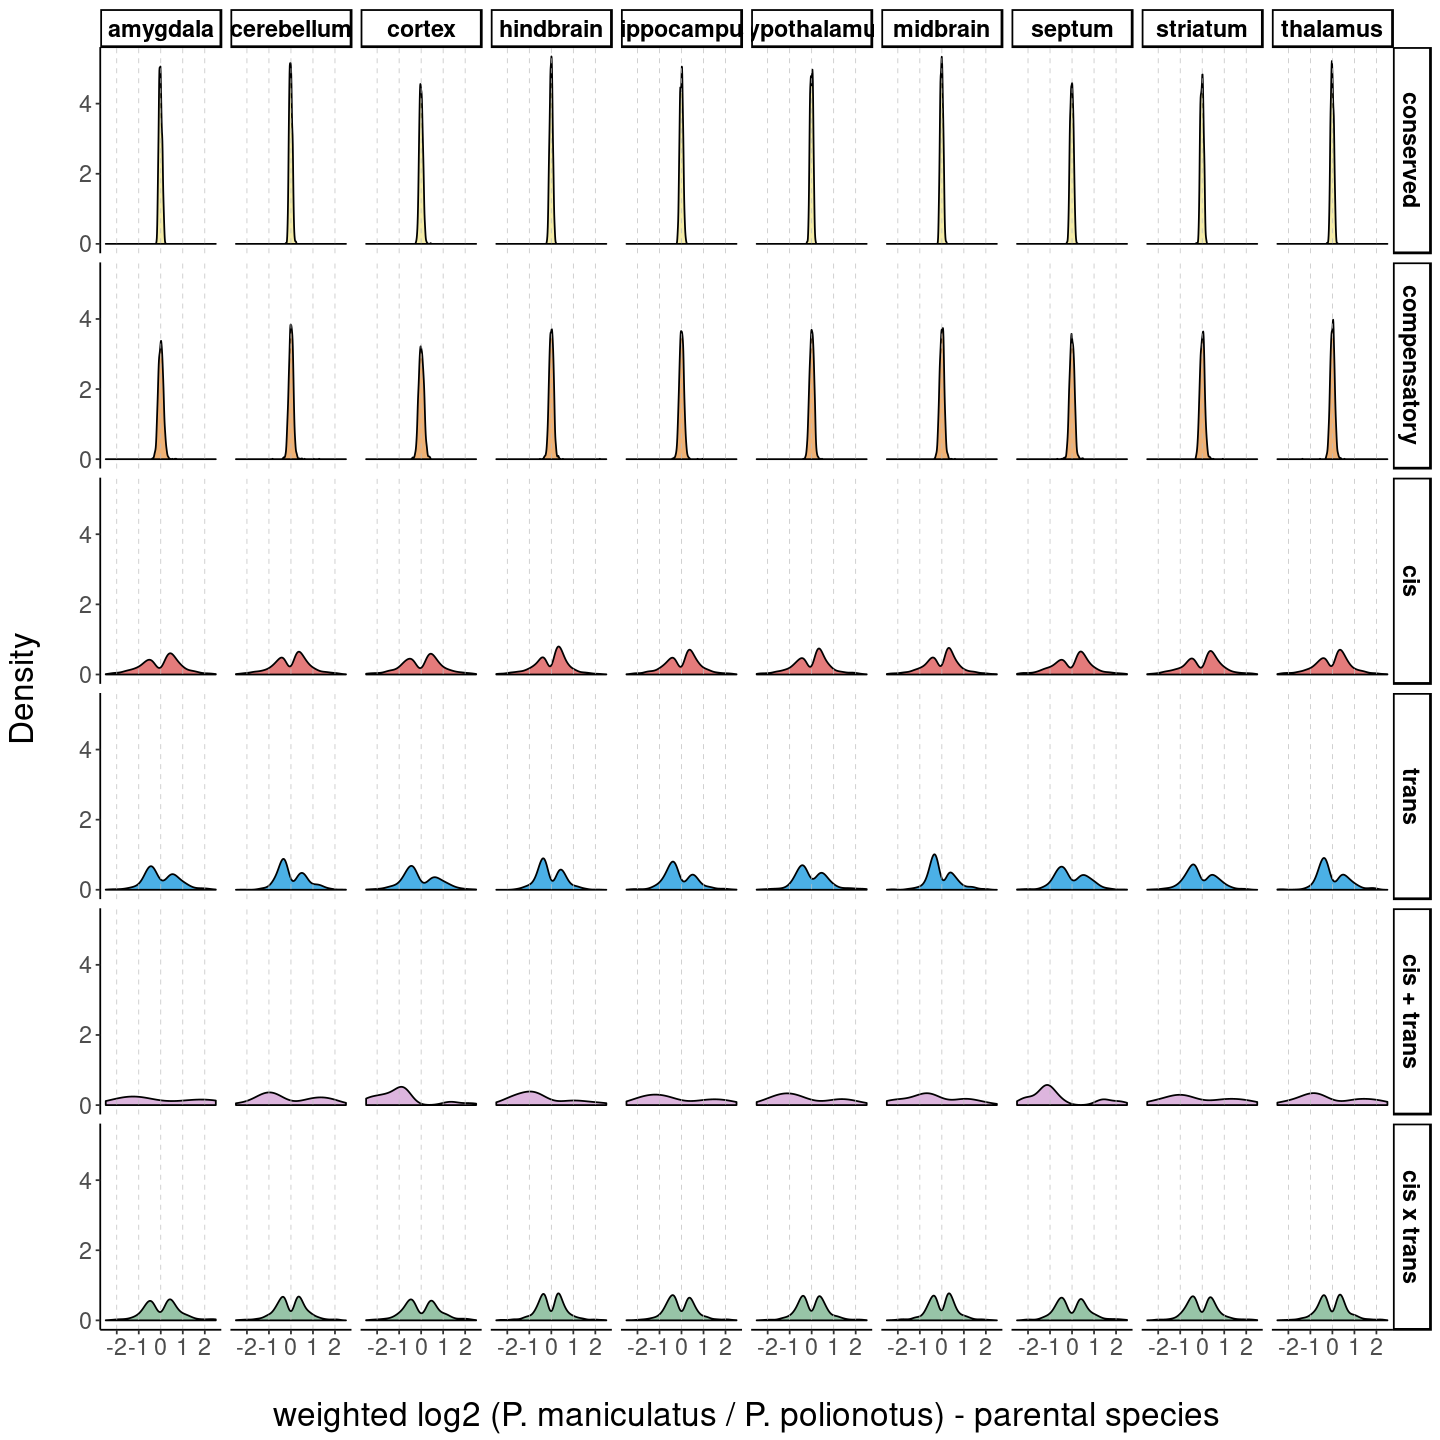

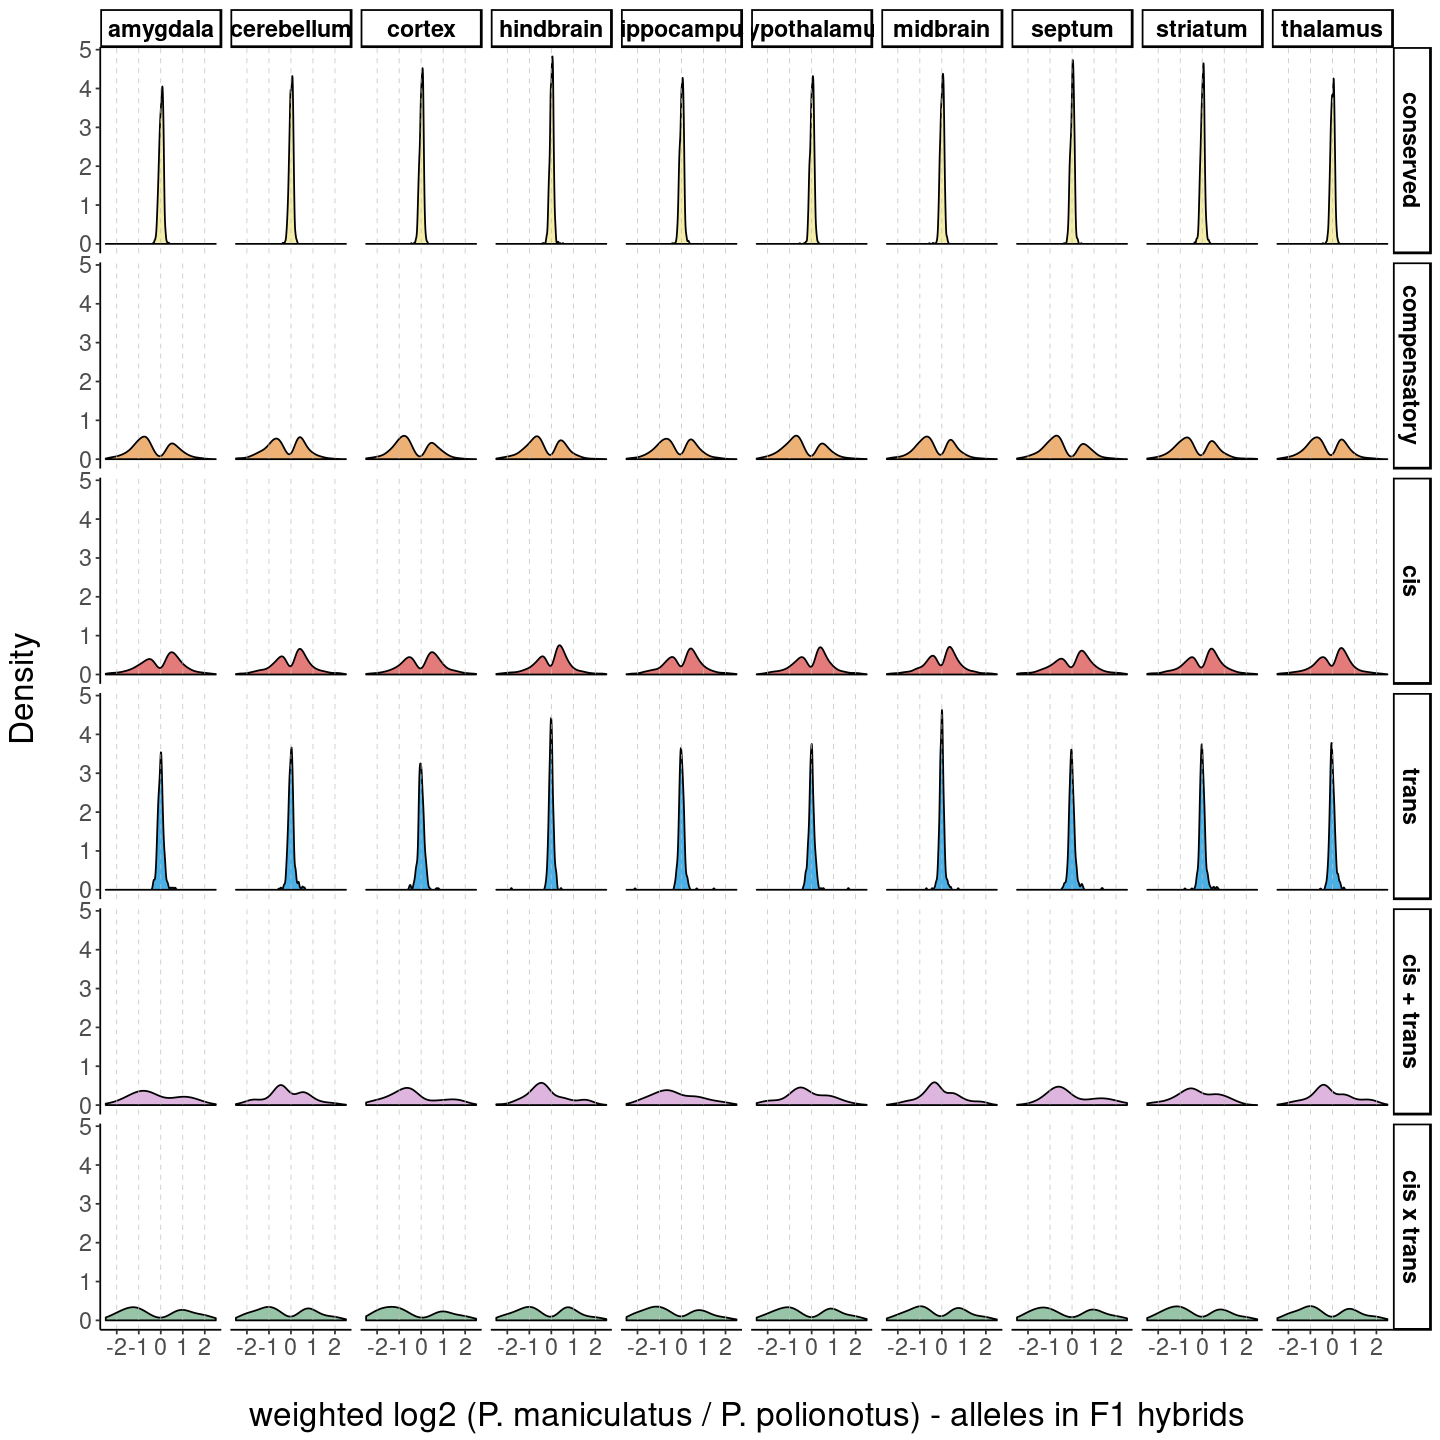

In [67]:
options(repr.plot.width=12, repr.plot.height=12)

mmdiff.results.filter.classes.weighted.all %>% 
    anti_join(pseudogenes, by="feature_id") %>% 
    filter(class_new!="unassigned") %>%
    ggplot( aes(x=ratio.par, fill=class_new)) + geom_density(alpha=0.75) + #ggtitle("All subregions\n") +
        xlab("\nweighted log2 (P. maniculatus / P. polionotus) - parental species") + ylab("Density\n") +
        theme_classic() + facet_grid(rows=vars(class_new), cols=vars(subregion)) + xlim(-2.5,2.5) + 
        geom_vline(xintercept=c(-2,-1,0,1,2), col="gray", linetype="dashed", size=0.2) + 
        theme(plot.title = element_text(color="black", size=14, face="bold",hjust=0.5)) + #coord_flip() +
        scale_fill_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                           'cis x trans'="#74B089",'cis + trans'="#D19CD3",unassigned="gray")) +
        theme(axis.text=element_text(size=14), axis.title=element_text(size=20)) + 
        labs(fill="Gene regulatory class") +
        theme(plot.title=element_text(color="black", size=20, face="bold", hjust=0.5)) +
        theme(strip.text.x=element_text(size=14, colour="black", angle=0, face="bold")) +
        theme(strip.text.y=element_text(size=14, colour="black", angle=270, face="bold")) +
        theme(legend.text=element_text(size=14), legend.title=element_text(size=15)) +
        theme(legend.position="none")

        #file_name=paste0(plot_path,"out_mmdiff.all_subregions.weightedLFC_by_class.parentals.facet_by_SR.posterior",thresh,".pdf")
        #if(!file.exists(file_name)) {
        #    ggsave(file_name, width=12, height=12)
        #}

mmdiff.results.filter.classes.weighted.all %>% 
    anti_join(pseudogenes, by="feature_id") %>% 
    filter(class_new!="unassigned") %>%
    ggplot( aes(x=ratio.F1s, fill=class_new)) + geom_density(alpha=0.75) + #ggtitle("All subregions\n") +
        xlab("\nweighted log2 (P. maniculatus / P. polionotus) - alleles in F1 hybrids") + ylab("Density\n") +
        theme_classic() + facet_grid(rows=vars(class_new), cols=vars(subregion)) + xlim(-2.5,2.5) + 
        geom_vline(xintercept=c(-2,-1,0,1,2), col="gray", linetype="dashed", size=0.2) + 
        theme(plot.title = element_text(color="black", size=14, face="bold",hjust=0.5)) + #coord_flip() +
        scale_fill_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                           'cis x trans'="#74B089",'cis + trans'="#D19CD3",unassigned="gray")) +
        theme(axis.text=element_text(size=14), axis.title=element_text(size=20)) + 
        labs(fill="Gene regulatory class") +
        theme(plot.title=element_text(color="black", size=20, face="bold", hjust=0.5)) +
        theme(strip.text.x=element_text(size=14, colour="black", angle=0, face="bold")) +
        theme(strip.text.y=element_text(size=14, colour="black", angle=270, face="bold")) +
        theme(legend.text=element_text(size=14), legend.title=element_text(size=15)) +
        theme(legend.position="none")

        #file_name=paste0(plot_path,"out_mmdiff.all_subregions.weightedLFC_by_class.hybrids.facet_by_SR.posterior",thresh,".pdf")
        #if(!file.exists(file_name)) {
        #    ggsave(file_name, width=12, height=12)
        #}

## Dominance/additivity

In [70]:
# following Gibson et al. 2004 (see Fig. 5)

thresh=0.75

mmdiff.results.filter.classes.only_dom_add <- lapply(mmdiff.results.filter, function(x) {
    x <- x %>%
    rename(postprob_cons=postprob_model0,postprob_cis=postprob_model1,postprob_trans=postprob_model2,
           postprob_cis_trans=postprob_model3,postprob_comp=postprob_model4) %>%
    mutate("BWs"=rowMeans(exp(select(., matches("mu_BW"))))) %>%
    mutate("POs"=rowMeans(exp(select(., matches("mu_PO"))))) %>%
    mutate("F1.BWs"=rowMeans(exp(select(., matches("mu_F1"))) %>% select(ends_with(".BW")))) %>%
    mutate("F1.POs"=rowMeans(exp(select(., matches("mu_F1"))) %>% select(ends_with(".PO")))) %>%
    mutate(reg_class_postprob = if_else(postprob_cons >= thresh, "conserved",
                            if_else(postprob_cis >= thresh, "cis",
                                if_else(postprob_trans >= thresh, "trans",
                                    if_else(postprob_cis_trans >= thresh, "cis & trans", 
                                            if_else(postprob_comp >= thresh, "compensatory","unassigned")))))) %>%
    mutate("ratio.par"=log2(BWs/POs), "ratio.F1s"=log2(F1.BWs/F1.POs)) %>%
    mutate("ratio"=ratio.par/ratio.F1s) %>%
    mutate(class_new = if_else(reg_class_postprob=="cis & trans" & ratio > 1,"cis + trans",
                              if_else(reg_class_postprob=="cis & trans" & ratio < 1,"cis x trans",as.character(reg_class_postprob)))) %>%
    mutate(class_new=fct_relevel(class_new,"unassigned","conserved","compensatory","cis","trans","cis + trans","cis x trans")) %>%
    mutate("midparent"=rowMeans(select(., c("BWs","POs"))),"midhybrid"=rowMeans(select(., c("F1.BWs","F1.POs")))) %>%
    mutate("dom_add_ratio"=(midhybrid-midparent)/abs(0.5*(BWs-POs))) %>% 
    select(-c(starts_with("mu_"), starts_with("sd_")))
})

In [71]:
# combine all subregions results

mmdiff.results.filter.classes.only_dom_add.all <- do.call(rbind, mmdiff.results.filter.classes.only_dom_add) %>% 
    rownames_to_column("subregion") %>% mutate(subregion=str_replace(subregion,"\\.\\d+",""))

In [72]:
mmdiff.results.filter.classes.only_dom_add.all %>% head()

subregion,feature_id,postprob_cons,postprob_cis,postprob_trans,postprob_cis_trans,postprob_comp,BWs,POs,F1.BWs,F1.POs,reg_class_postprob,ratio.par,ratio.F1s,ratio,class_new,midparent,midhybrid,dom_add_ratio
amygdala,Zfp160,5.614450e-02,0.02418464,0.790638106,0.11963888,9.393874e-03,2.309587,3.159708,2.803536,2.431525,trans,-0.45215604,0.2053858,-2.2014959,trans,2.734648,2.617531,-0.2755303
amygdala,Zfp53,2.811389e-01,0.15621875,0.035426590,0.06195907,4.652567e-01,2.152152,2.038091,2.316427,1.620143,unassigned,0.07856127,0.5157797,0.1523156,unassigned,2.095121,1.968285,-2.2240100
amygdala,Ppp2r1a,1.565397e-02,0.61624374,0.006943179,0.13775967,2.233994e-01,210.127789,183.845228,225.782437,173.611724,unassigned,0.19277524,0.3790689,0.5085494,unassigned,196.986508,199.697080,0.2062639
amygdala,Spaca6,3.333673e-01,0.36782418,0.136306237,0.04740217,1.151001e-01,20.933096,26.137433,21.680563,26.354908,unassigned,-0.32033177,-0.2816694,1.1372614,unassigned,23.535264,24.017735,0.1854110
amygdala,Gm18193,4.304871e-02,0.69333391,0.053975333,0.13253449,7.710756e-02,1.247420,1.946069,1.044930,1.765672,unassigned,-0.64161617,-0.7568112,0.8477889,unassigned,1.596744,1.405301,-0.5480377
amygdala,Zik1,3.043899e-05,0.26912750,0.038568629,0.69220687,6.655271e-05,1.786370,3.072309,1.978221,2.589833,unassigned,-0.78229253,-0.3886560,2.0128150,unassigned,2.429339,2.284027,-0.2260020


Warning message:
“Removed 257 rows containing non-finite values (stat_density).”

Warning message:
“Removed 257 rows containing non-finite values (stat_density).”

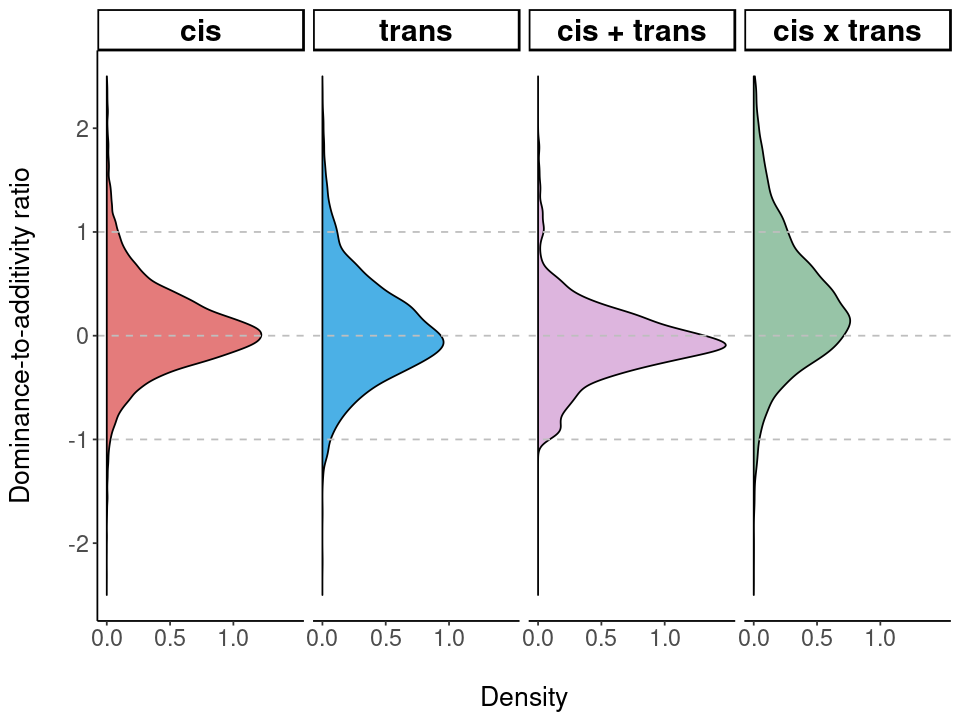

In [73]:
options(repr.plot.width=8, repr.plot.height=6)


mmdiff.results.filter.classes.only_dom_add.all %>% 
    anti_join(pseudogenes,by="feature_id") %>%
    filter(!class_new %in% c("unassigned","conserved","compensatory")) %>%
    ggplot( aes(x=dom_add_ratio, fill=class_new)) + geom_density(alpha=0.75) +
        xlab("Dominance-to-additivity ratio\n") + ylab("\nDensity") +
        theme_classic() + facet_grid(cols=vars(class_new)) + xlim(-2.5,2.5) + #, rows=vars(subregion)
        theme(plot.title = element_text(color="black", size=14, face="bold",hjust=0.5)) + coord_flip() +
        scale_fill_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                           'cis x trans'="#74B089",'cis + trans'="#D19CD3")) +
        theme(axis.text=element_text(size=14), axis.title=element_text(size=16)) + 
        theme(plot.title=element_text(color="black", size=18, face="bold", hjust=0.5)) +
        theme(strip.text.x=element_text(size=18, colour="black", angle=0, face="bold")) +
        theme(legend.position="none") +
        geom_vline(xintercept=c(-1,0,1), col="gray", linetype="dashed") +
        scale_y_continuous(breaks=c(0,0.5,1))
        

file_name=paste0(plot_path,"out_mmdiff.all_subregions.dom_add_ratios.posterior",thresh,".pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=8, height=8)
}

## Compare regulation across subregions

In [75]:
# NOTE: this is slightly different from above (Dominance/additivity)

thresh=0.75

mmdiff.results.filter.classes.dom_add <- lapply(mmdiff.results.filter, function(x) {
    x <- x %>%
    rename(postprob_cons=postprob_model0,postprob_cis=postprob_model1,postprob_trans=postprob_model2,
           postprob_cis_trans=postprob_model3,postprob_comp=postprob_model4) %>%
    mutate("BWs"=rowMeans(exp(select(., matches("mu_BW"))))) %>%
    mutate("POs"=rowMeans(exp(select(., matches("mu_PO"))))) %>%
    mutate("F1.BWs"=rowMeans(exp(select(., matches("mu_F1"))) %>% select(ends_with(".BW")))) %>%
    mutate("F1.POs"=rowMeans(exp(select(., matches("mu_F1"))) %>% select(ends_with(".PO")))) %>%
    mutate(reg_class_postprob = if_else(postprob_cons >= thresh, "conserved",
                            if_else(postprob_cis >= thresh, "cis",
                                if_else(postprob_trans >= thresh, "trans",
                                    if_else(postprob_cis_trans >= thresh, "cis & trans", 
                                            if_else(postprob_comp >= thresh, "compensatory","unassigned")))))) %>%
    mutate("ratio.par"=log2(BWs/POs), "ratio.F1s"=log2(F1.BWs/F1.POs)) %>%
    mutate("ratio"=ratio.par/ratio.F1s) %>%
    mutate(reg_class_postprob = if_else(reg_class_postprob=="cis & trans" & ratio > 1,"cis + trans",
                              if_else(reg_class_postprob=="cis & trans" & ratio < 1,"cis x trans",as.character(reg_class_postprob)))) %>%
    mutate("midparent"=rowMeans(select(., c("BWs","POs"))),"midhybrid"=rowMeans(select(., c("F1.BWs","F1.POs")))) %>%
    mutate("dom_add_ratio"=(midhybrid-midparent)/abs(0.5*(BWs-POs))) %>% 
    select(-c(BWs,POs,F1.BWs,F1.POs,ratio.par,ratio.F1s,ratio,midparent,midhybrid))
})

In [ ]:
# write filtered data sets to files

sapply(names(mmdiff.results.filter.classes.dom_add), 
    function (x) write.table(mmdiff.results.filter.classes.dom_add[[x]], 
        file=paste0("out_mmdiff.",x,".ASE.covarSex.prior_flat0.2.poly.filtered.reg_class.dom_add.ratio.out"), 
        quote=F, col.names=T, row.names=F, sep="\t"))

In [ ]:
# read in data from files
mmdiff.reg_class.filelist <- list.files(pattern=".ASE.*.prior_flat0.2.poly.filtered.reg_class.dom_add.ratio.out", recursive=F) %>% 
    lapply(., grep, pattern="control", value=T, invert=T) %>% compact %>% unlist()

print(mmdiff.reg_class.filelist)

tissues = sapply(strsplit(mmdiff.reg_class.filelist,"\\."), `[`, 2)
names(mmdiff.reg_class.filelist) = tissues

mmdiff.results.filter.classes.dom_add <- llply(mmdiff.reg_class.filelist, read.table, sep="\t", header=T, colClasses=c("feature_id"="character"))

llply(mmdiff.results.filter.classes.dom_add, dim) %>% as.data.frame()

In [76]:
mmdiff.results.filter.classes.dom_add.tidy <- llply(mmdiff.results.filter.classes.dom_add, select, feature_id, reg_class_postprob)
for (tissue in tissues){mmdiff.results.filter.classes.dom_add.tidy[[tissue]]$tissue <- tissue}

mmdiff.comp <- llply(mmdiff.results.filter.classes.dom_add.tidy) %>% do.call("rbind", .)

In [77]:
mmdiff.comp %>% mutate(Gene_regulatory_class=fct_relevel(reg_class_postprob,"conserved","compensatory","cis",
                                                "trans","cis x trans","cis + trans","unassigned")) %>% 
    mutate("gene_class"=if_else(feature_id %in% pseudogenes$feature_id, "pseudogene",
                               if_else(feature_id %in% coding$feature_id, "coding", "other"))) %>%
    group_by(tissue,Gene_regulatory_class,gene_class) %>% tally() %>% 
    spread(tissue,n) 

Gene_regulatory_class,gene_class,amygdala,cerebellum,cortex,hindbrain,hippocampus,hypothalamus,midbrain,septum,striatum,thalamus
conserved,coding,1148,869,1014,1052,988,1173,1049,1105,920,1014
conserved,other,30,30,28,34,41,27,34,34,27,23
conserved,pseudogene,8,9,5,10,9,4,11,8,4,9
compensatory,coding,1547,1664,1577,1885,1712,1601,1826,1576,1642,1673
compensatory,other,45,70,49,64,53,50,64,41,52,51
compensatory,pseudogene,18,22,17,19,19,17,24,20,17,20
cis,coding,1442,1863,1610,1822,1815,1716,1780,1487,1892,1842
cis,other,176,233,179,180,198,181,182,182,234,204
cis,pseudogene,65,71,77,75,74,73,89,70,82,84
trans,coding,199,428,291,325,359,282,372,242,356,397


In [78]:
mmdiff.comp %>% mutate(Gene_regulatory_class=fct_relevel(reg_class_postprob,"conserved","compensatory","cis",
                                                "trans","cis + trans","cis x trans","unassigned")) %>% 
    mutate("gene_class"=if_else(feature_id %in% pseudogenes$feature_id, "pseudogene",
                               if_else(feature_id %in% coding$feature_id, "coding", "other"))) %>%
    group_by(tissue,Gene_regulatory_class,gene_class) %>% tally() %>% 
    group_by(tissue,gene_class) %>% mutate(total_genes=sum(n), prop_genes=n/total_genes) %>%
    select(-n,-total_genes) %>% spread(tissue,prop_genes) %>% mutate_if(is.numeric, round, 3) 

`mutate_if()` ignored the following grouping variables:
Column `gene_class`


Gene_regulatory_class,gene_class,amygdala,cerebellum,cortex,hindbrain,hippocampus,hypothalamus,midbrain,septum,striatum,thalamus
conserved,coding,0.094,0.075,0.085,0.085,0.083,0.094,0.086,0.090,0.077,0.085
conserved,other,0.024,0.024,0.023,0.030,0.034,0.021,0.029,0.028,0.021,0.021
conserved,pseudogene,0.019,0.021,0.013,0.024,0.021,0.009,0.026,0.019,0.010,0.022
compensatory,coding,0.127,0.143,0.132,0.153,0.144,0.128,0.150,0.128,0.137,0.140
compensatory,other,0.036,0.055,0.041,0.057,0.044,0.039,0.055,0.033,0.040,0.046
compensatory,pseudogene,0.043,0.051,0.043,0.045,0.044,0.040,0.057,0.046,0.040,0.049
cis,coding,0.118,0.160,0.135,0.148,0.152,0.138,0.147,0.121,0.158,0.154
cis,other,0.141,0.183,0.149,0.160,0.165,0.142,0.156,0.148,0.180,0.183
cis,pseudogene,0.154,0.164,0.193,0.177,0.172,0.170,0.211,0.162,0.195,0.206
trans,coding,0.016,0.037,0.024,0.026,0.030,0.023,0.031,0.020,0.030,0.033


### Plot comparison across subregions

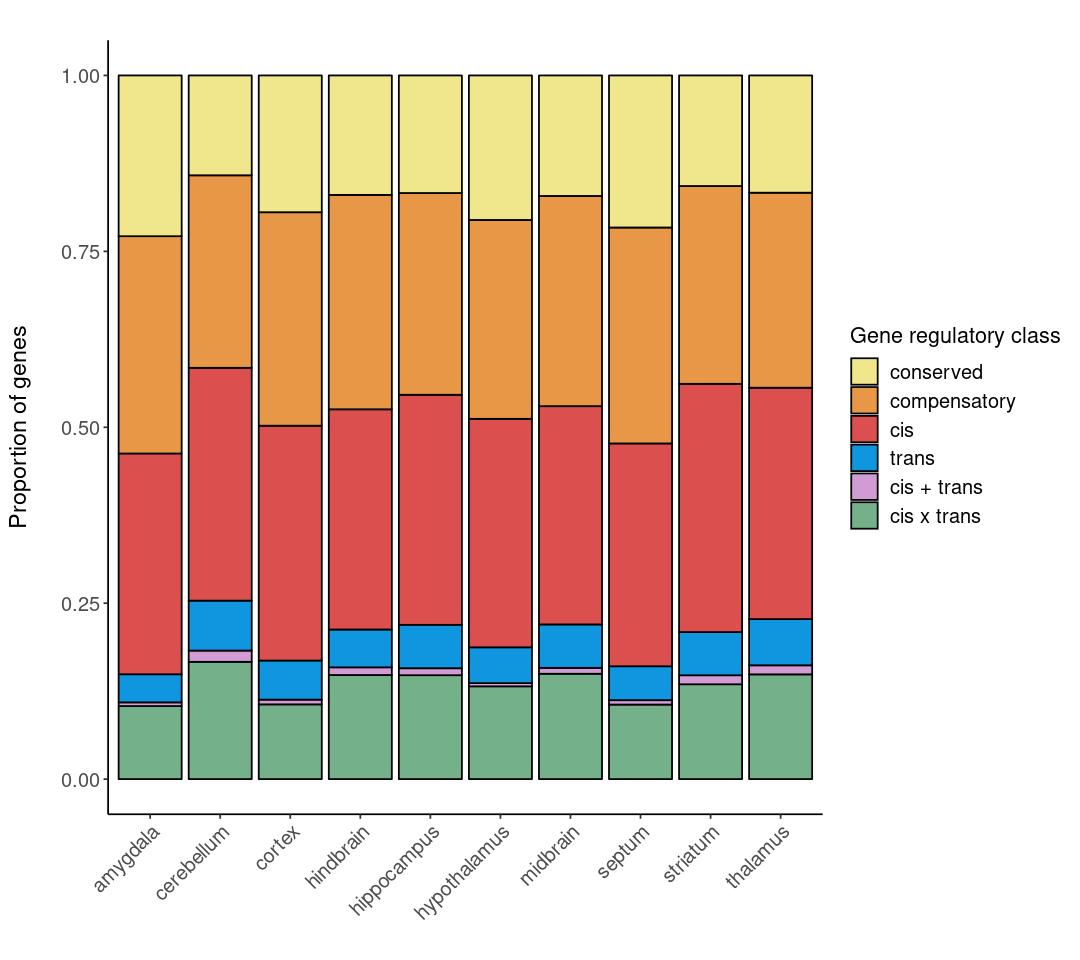

In [79]:
options(repr.plot.width=9, repr.plot.height=8)

mmdiff.comp %>% mutate(reg_class_postprob=fct_relevel(reg_class_postprob,"conserved","compensatory","cis","trans",
                                              "cis + trans","cis x trans","unassigned")) %>% 
    filter(reg_class_postprob!="unassigned") %>%
    anti_join(pseudogenes,by="feature_id") %>%
    group_by(tissue,reg_class_postprob) %>% tally() %>% 
    group_by(tissue) %>% mutate(total_genes=sum(n), prop_genes=n/total_genes) %>%
    ggplot( aes(x=tissue, y=prop_genes, fill=reg_class_postprob)) + 
    geom_bar(stat="identity", color="black", position="stack") + theme_classic() + 
        labs(y="Proportion of genes\n", x="", title="") + 
        theme(plot.title = element_text(color="black", size=14, face="bold",hjust=0.5)) +
        scale_fill_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                               'cis x trans'="#74B089",'cis + trans'="#D19CD3","unassigned"="gray90")) +
        theme(axis.text.x=element_text(angle=45, hjust=1, size=12), axis.text.y=element_text(size=12)) + 
        theme(axis.title=element_text(size=14)) + labs(fill="Gene regulatory class") +
        theme(legend.text=element_text(size=12), legend.title=element_text(size=13))


file_name=paste0(plot_path,"out_mmdiff.all_subregions.regulation.barplot.wo_unassigned.rel.posterior",thresh,".pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=9, height=8)
}

In [104]:
# min and max proportion across subregions
mmdiff.comp %>% mutate(reg_class_postprob=fct_relevel(reg_class_postprob,"conserved","compensatory","cis","trans",
                                              "cis + trans","cis x trans","unassigned")) %>% 
    filter(reg_class_postprob!="unassigned") %>%
    anti_join(pseudogenes,by="feature_id") %>%
    group_by(tissue,reg_class_postprob) %>% tally() %>% 
    group_by(tissue) %>% mutate(total_genes=sum(n), prop_genes=n/total_genes) %>% select(-total_genes,-n) %>%
    spread(reg_class_postprob,prop_genes) %>% ungroup() %>% select(-tissue) %>% 
    summarize_all(funs(min=min(.), max=max(.), var=var(.))) %>% t() 

conserved_min,1.418876e-01
compensatory_min,2.736742e-01
cis_min,3.101976e-01
trans_min,3.995345e-02
cis + trans_min,4.621705e-03
cis x trans_min,1.037626e-01
conserved_max,2.284717e-01
compensatory_max,3.087665e-01
cis_max,3.528045e-01
trans_max,7.102273e-02
cis + trans_max,1.594066e-02


In [100]:
# ...same, but for pseudogenes
mmdiff.comp %>% mutate(reg_class_postprob=fct_relevel(reg_class_postprob,"conserved","compensatory","cis","trans",
                                              "cis + trans","cis x trans","unassigned")) %>% 
    filter(reg_class_postprob!="unassigned") %>%
    semi_join(pseudogenes,by="feature_id") %>%
    group_by(tissue,reg_class_postprob) %>% tally() %>% 
    group_by(tissue) %>% mutate(total_genes=sum(n), prop_genes=n/total_genes) %>% select(-total_genes,-n) %>%
    spread(reg_class_postprob,prop_genes) %>% ungroup() %>% select(-tissue) %>% 
    summarize_all(funs(min=min(.), max=max(.))) %>% t() 

conserved_min,0.029197080
compensatory_min,0.124087591
cis_min,0.503546099
trans_min,0.009259259
cis + trans_min,0.007299270
cis x trans_min,0.120000000
conserved_max,0.074074074
compensatory_max,0.166666667
cis_max,0.626016260
trans_max,0.056910569
cis + trans_max,0.035460993


In [91]:
# DE vs. non-DE in parents

mmdiff.comp %>% mutate(reg_class_postprob=fct_relevel(reg_class_postprob,"conserved","compensatory","cis","trans",
                                              "cis + trans","cis x trans","unassigned")) %>% 
    filter(reg_class_postprob!="unassigned") %>%
    anti_join(pseudogenes,by="feature_id") %>%
    mutate("DEparents"=if_else(reg_class_postprob=="conserved" | reg_class_postprob=="compensatory","notDE","DE")) %>% 
    group_by(tissue,DEparents) %>% tally() %>% 
    group_by(tissue) %>% mutate(total_genes=sum(n), prop_genes=n/total_genes) %>%
    group_by(DEparents) %>% summarize(min=min(prop_genes),max=max(prop_genes))

DEparents,min,max
DE,0.4627618,0.5844381
notDE,0.4155619,0.5372382


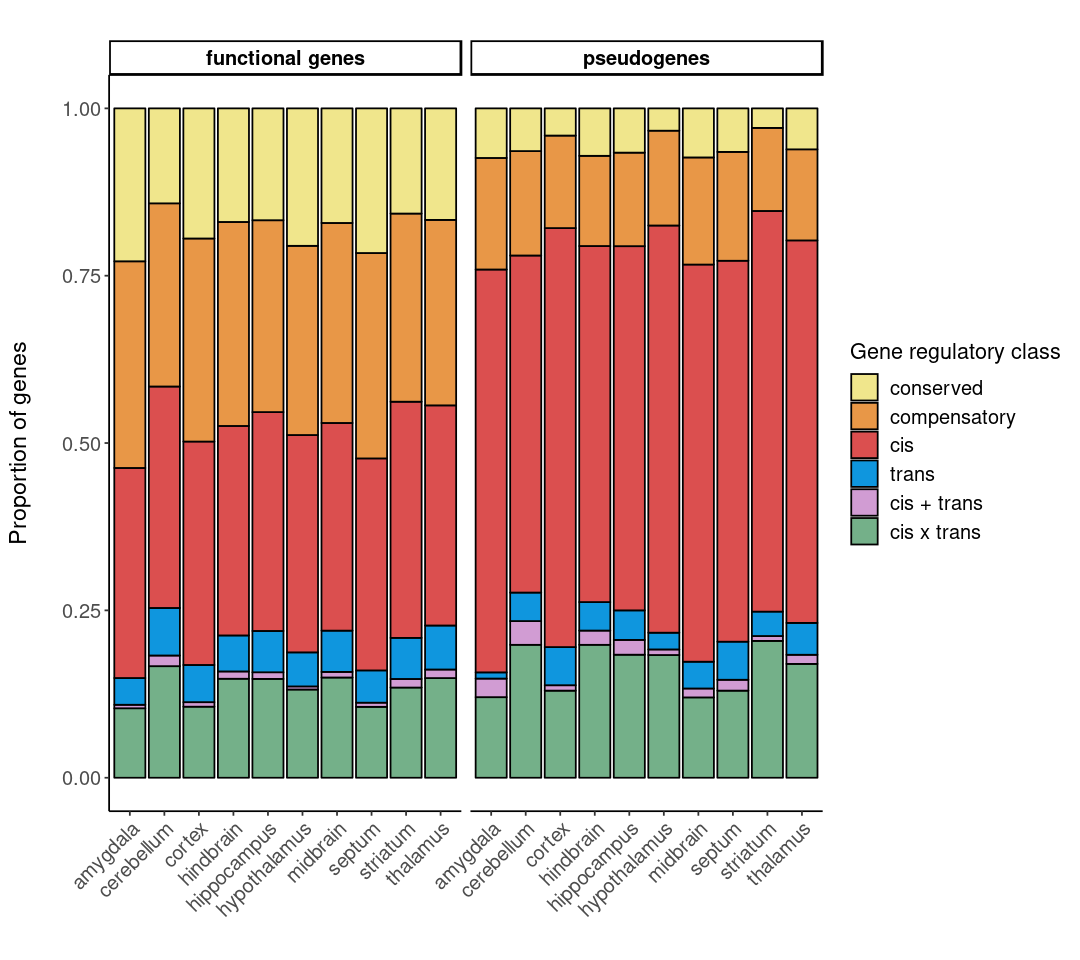

In [101]:
# pseudogenes vs. coding in one plot

options(repr.plot.width=9, repr.plot.height=8)

mmdiff.comp %>% mutate(reg_class_postprob=fct_relevel(reg_class_postprob,"conserved","compensatory","cis","trans",
                                              "cis + trans","cis x trans","unassigned")) %>% 
    mutate("gene_type"=if_else(feature_id %in% pseudogenes$feature_id, "pseudogenes", "functional genes")) %>%
    #                           if_else(feature_id %in% coding$feature_id, "protein coding", "other"))) %>% 
    #filter(gene_type!="other") %>%
    filter(reg_class_postprob!="unassigned") %>%
    group_by(tissue,reg_class_postprob,gene_type) %>% tally() %>% 
    group_by(tissue,gene_type) %>% mutate(total_genes=sum(n), prop_genes=n/total_genes) %>%
    ggplot( aes(x=tissue, y=prop_genes, fill=reg_class_postprob)) + 
    geom_bar(stat="identity", color="black", position="stack") + theme_classic() + 
        labs(y="Proportion of genes\n", x="", title="") + 
        theme(plot.title = element_text(color="black", size=14, face="bold",hjust=0.5)) +
        scale_fill_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                               'cis x trans'="#74B089",'cis + trans'="#D19CD3","unassigned"="gray90")) +
        facet_wrap(~gene_type) +
        theme(axis.text.x=element_text(angle=45, hjust=1, size=12), axis.text.y=element_text(size=12)) + 
        theme(axis.title=element_text(size=14)) + labs(fill="Gene regulatory class") +
        theme(legend.text=element_text(size=12), legend.title=element_text(size=13)) +
        theme(strip.text.x=element_text(size=12, colour="black", angle=0, face="bold")) 

file_name=paste0(plot_path,"out_mmdiff.all_subregions.regulation.barplot.pseudogenes.wo_unassigned.rel.posterior",thresh,".pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=9, height=8)
}

### Enrichment analyses

In [113]:
# genes consistently assigned to only one class
class="compensatory"

DE.matrix <- mmdiff.comp %>% 
    anti_join(pseudogenes,by="feature_id") %>%
    spread(tissue,reg_class_postprob) %>% na_if(., "unassigned") %>%
    mutate("no_classes"=apply(select(.,-feature_id), 1, function(x) n_distinct(unlist(x),na.rm = T))) %>%
    filter(no_classes==1) %>% replace(., is.na(.), "unassigned") %>% 
    mutate("fg"=if_else(rowSums(.==class) > 0, "1", "0"))  %>% arrange(feature_id) 

DE.matrix %>% group_by(fg) %>% tally()

DEgenes.vector <- as.vector(as.integer(DE.matrix$fg))
names(DEgenes.vector) <- DE.matrix$feature_id

bg <- DE.matrix %>% select(feature_id)
fg <- DE.matrix %>% filter(fg=="1") %>% select(feature_id)
                              
fg.vec <- fg %>% unlist() %>% as.vector()
bg.vec <- bg %>% unlist() %>% as.vector()
                              
# write to file

file_name.bg = paste0(plot_path,"out_mmdiff.BW_PO_F1.all_subregions.only_",class,".postprob",thresh,".bg.genelist.tsv")
file_name.fg = paste0(plot_path,"out_mmdiff.BW_PO_F1.all_subregions.only_",class,".postprob",thresh,".fg.genelist.tsv")

if(!file.exists(file_name.bg)) {
    write_tsv(bg, file_name.bg, col_names=F) 
    write_tsv(fg, file_name.fg, col_names=F)
}

fg,n
0,4818
1,1782


In [114]:
enrichResult.species <- WebGestaltR(enrichMethod="ORA", organism="mmusculus", hostName="https://www.webgestalt.org/",
    enrichDatabase=c("geneontology_Biological_Process_noRedundant","geneontology_Cellular_Component_noRedundant",
                         "geneontology_Molecular_Function_noRedundant","phenotype_Mammalian_Phenotype_Ontology",
                            "pathway_KEGG","pathway_Panther","pathway_Reactome","network_Transcription_Factor_target"),
    interestGene=fg.vec, interestGeneType="genesymbol", 
    referenceGene=bg.vec, referenceGeneType="genesymbol", 
    minNum=5, maxNum=2000, sigMethod="fdr", fdrMethod="BH", fdrThr=0.05, reportNum=1000, setCoverNum=10,
    dagColor="continuous", isOutput=T, outputDirectory=plot_path,
    projectName=paste0("out_WebGestaltR.regulation.only_",class))

Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
Remain is 0, ending weighted set cover
Generate the final report...


Warning message in system2(zip, args):
“error in running command”

Results can be found in the /n/hoekstra_lab_tier1/Users/akautt/projects/Peromyscus_RNAseq_brain/results_plots_tables_new//Project_out_WebGestaltR_regulation_only_compensatory!


## Inter-region regulation change

### Summaries

In [115]:
# assign genes to foreground and background

classchange="all"

reg_change.matrix <- mmdiff.comp %>% 
    anti_join(pseudogenes,by="feature_id") %>%
    spread(tissue,reg_class_postprob) %>% na_if(., "unassigned") %>%
    mutate("no_classes"=apply(select(.,-feature_id), 1, function(x) n_distinct(unlist(x),na.rm = T))) %>%
    filter(no_classes>=2) %>% replace(., is.na(.), "unassigned") %>%
    mutate("fg"=1)
                              
reg_change.matrix %>% group_by(fg) %>% tally()

fg,n
1,6261


In [116]:
mmdiff.comp %>% spread(tissue,reg_class_postprob) %>% na_if(., "unassigned") %>%
    anti_join(pseudogenes,by="feature_id") %>%
    mutate("no_classes"=apply(select(.,-feature_id), 1, function(x) n_distinct(unlist(x),na.rm = T))) %>%   
    group_by(no_classes) %>% tally() %>% mutate("proportion"=round(n/sum(n),3)) %>% 
    mutate("percentage"=proportion*100) 

cat("Total number of assayed genes:",
    mmdiff.comp %>% spread(tissue,reg_class_postprob) %>% anti_join(pseudogenes,by="feature_id") %>% nrow())

no_classes,n,proportion,percentage
0,2447,0.160,16.0
1,6600,0.431,43.1
2,4975,0.325,32.5
3,1171,0.076,7.6
4,109,0.007,0.7
5,6,0.000,0.0


Total number of assayed genes: 15308

In [117]:
cat("Number of genes only assigned in one subregion overall: ",
mmdiff.comp %>% spread(tissue,reg_class_postprob) %>% na_if(., "unassigned") %>%
    anti_join(pseudogenes,by="feature_id") %>%
    mutate("no_classes"=apply(select(.,-feature_id), 1, function(x) n_distinct(unlist(x),na.rm = T))) %>% 
    replace(., is.na(.), "unassigned") %>% mutate("no_assigned"=10-rowSums(.=="unassigned")) %>% 
    filter(no_assigned==1) %>% nrow())

Number of genes only assigned in one subregion overall:  1686

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

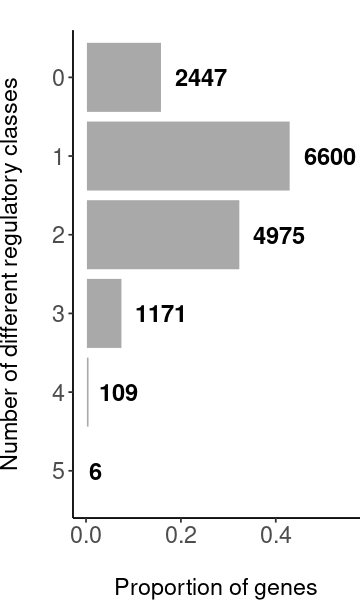

In [118]:
options(repr.plot.width=3, repr.plot.height=5)

mmdiff.comp %>% spread(tissue,reg_class_postprob) %>% na_if(., "unassigned") %>%
    anti_join(pseudogenes,by="feature_id") %>%
    mutate("no_classes"=apply(select(.,-feature_id), 1, function(x) n_distinct(unlist(x),na.rm = T))) %>%   
    group_by(no_classes) %>% tally() %>% mutate("prop"=n/sum(n)) %>%
    ggplot( aes(x=reorder(no_classes, desc(no_classes)), y=prop)) + geom_histogram(stat="identity", col="white", fill="darkgray", alpha=1) +  
        labs(title="", y="\nProportion of genes", x="Number of different regulatory classes\n") + 
        theme_classic() + theme(plot.margin = margin(0, 0, 0, 0, "cm")) +
        theme(axis.text=element_text(size=14), axis.title=element_text(size=14)) + 
        geom_text(aes(label=n), hjust=-0.25, vjust=0.5, size=5, color="black", fontface = "bold") +
        coord_flip(ylim=c(0,0.55))

file_name=paste0(plot_path,"out_mmdiff.all_subregions.regulation.reg_changes.histogram.posterior",thresh,".pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=3, height=5)
}

In [119]:
reg_change.matrix.one_classes <- mmdiff.comp %>% spread(tissue,reg_class_postprob) %>% na_if(., "unassigned") %>%
    anti_join(pseudogenes,by="feature_id") %>%
    mutate("no_classes"=apply(select(.,-feature_id), 1, function(x) n_distinct(unlist(x),na.rm = T))) %>%
    filter(no_classes==1) %>% select(-no_classes) %>% replace(., is.na(.), "unassigned") %>%
    mutate("classes"=case_when(
                rowSums(.=="conserved") > 0 ~ "conserved",
                rowSums(.=="compensatory") > 0 ~ "compensatory",
                rowSums(.=="cis") > 0 ~ "cis",
                rowSums(.=="trans") > 0 ~ "trans",
                rowSums(.=="cis + trans") > 0 ~ "cis + trans",
                rowSums(.=="cis x trans") > 0 ~ "cis x trans"))  

In [120]:
reg_change.matrix.one_classes %>% group_by(classes) %>% tally() %>% arrange(desc(n)) %>%
    mutate("proportion"=round(n/sum(n),3)) %>% mutate("percentage"=proportion*100) 

classes,n,proportion,percentage
cis,2583,0.391,39.1
compensatory,1782,0.270,27.0
conserved,1251,0.190,19.0
cis x trans,543,0.082,8.2
trans,393,0.060,6.0
cis + trans,48,0.007,0.7


In [121]:
# w/o genes only assigned in a single subregion

reg_change.matrix.one_classes %>% mutate("no_assigned"=10-rowSums(.=="unassigned")) %>% 
    filter(no_assigned!=1) %>% group_by(classes) %>% tally() %>% arrange(desc(n)) %>%
    mutate("proportion"=round(n/sum(n),3)) %>% mutate("percentage"=proportion*100) 

classes,n,proportion,percentage
cis,1871,0.381,38.1
compensatory,1407,0.286,28.6
conserved,975,0.198,19.8
cis x trans,448,0.091,9.1
trans,196,0.040,4.0
cis + trans,17,0.003,0.3


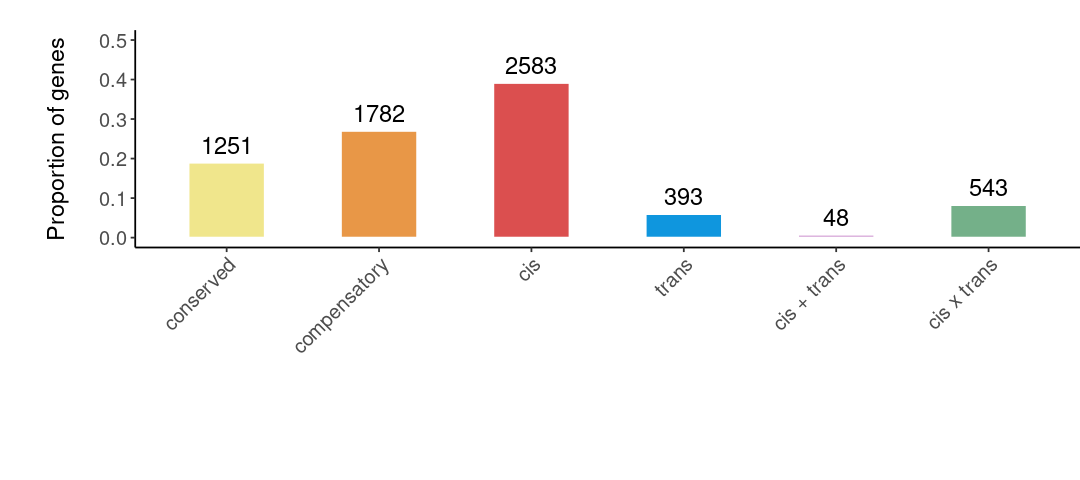

In [122]:
options(repr.plot.width=9, repr.plot.height=4)

reg_change.matrix.one_classes %>% group_by(classes) %>% tally() %>% arrange(desc(n)) %>%
    mutate("prop"=n/sum(n)) %>% 
    mutate(classes=fct_relevel(classes,"conserved","compensatory","cis","trans",
                                              "cis + trans","cis x trans")) %>%
    ggplot( aes(x=classes, y=prop, fill=classes)) + 
        geom_bar(aes(x=classes), stat="identity", color="white", width=0.5) + 
        scale_fill_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                               'cis x trans'="#74B089",'cis + trans'="#D19CD3")) +
        labs(title="", y="Proportion of genes\n",x="") + coord_cartesian(ylim=c(0,0.5)) +
        theme_classic() + theme(plot.margin = margin(0, 0, 2, 1, "cm")) +
        theme(axis.text.x=element_text(size=12, angle=45, hjust=1), axis.text.y=element_text(size=12),
              axis.title=element_text(size=14)) + 
        geom_text(aes(label=n), hjust=0.5, vjust=-0.5, size=5, color="black") +
        theme(legend.position="null")

file_name=paste0(plot_path,"out_mmdiff.all_subregions.regulation.one_class.histogram.posterior",thresh,".pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=9, height=4)
}

In [ ]:
options(repr.plot.width=9, repr.plot.height=4)

one_class.dat <- reg_change.matrix.one_classes %>% group_by(classes) %>% tally() %>% arrange(desc(n)) %>%
    mutate(classes=fct_relevel(classes,"conserved","compensatory","cis","trans",
                                              "cis + trans","cis x trans")) %>% 
    spread(key=classes,value=n)

waffle(one_class.dat / 10, rows=20, colors=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                               'cis x trans'="#74B089",'cis + trans'="#D19CD3"), 
      xlab="1 square = 10 genes")

In [123]:
reg_change.matrix.two_classes <- mmdiff.comp %>% spread(tissue,reg_class_postprob) %>% na_if(., "unassigned") %>%
    anti_join(pseudogenes,by="feature_id") %>%
    mutate("no_classes"=apply(select(.,-feature_id), 1, function(x) n_distinct(unlist(x),na.rm = T))) %>%
    filter(no_classes==2) %>% select(-no_classes) %>% replace(., is.na(.), "unassigned") %>%
    mutate("classes"=case_when(
                rowSums(.=="conserved") > 0 & rowSums(.=="compensatory") > 0 ~ "conserved & compensatory",
                rowSums(.=="conserved") > 0 & rowSums(.=="cis") > 0 ~ "conserved & cis",
                rowSums(.=="conserved") > 0 & rowSums(.=="trans") > 0 ~ "conserved & trans",
                rowSums(.=="conserved") > 0 & rowSums(.=="cis + trans") > 0 ~ "conserved & cis + trans",
                rowSums(.=="conserved") > 0 & rowSums(.=="cis x trans") > 0 ~ "conserved & cis x trans",
                rowSums(.=="compensatory") > 0 & rowSums(.=="cis") > 0 ~ "compensatory & cis",
                rowSums(.=="compensatory") > 0 & rowSums(.=="trans") > 0 ~ "compensatory & trans",
                rowSums(.=="compensatory") > 0 & rowSums(.=="cis + trans") > 0 ~ "compensatory & cis + trans",
                rowSums(.=="compensatory") > 0 & rowSums(.=="cis x trans") > 0 ~ "compensatory & cis x trans",
                rowSums(.=="cis") > 0 & rowSums(.=="trans") > 0 ~ "cis & trans",
                rowSums(.=="cis") > 0 & rowSums(.=="cis + trans") > 0 ~ "cis & cis + trans",
                rowSums(.=="cis") > 0 & rowSums(.=="cis x trans") > 0 ~ "cis & cis x trans",
                rowSums(.=="trans") > 0 & rowSums(.=="cis + trans") > 0 ~ "trans & cis + trans",
                rowSums(.=="trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "trans & cis x trans",
                rowSums(.=="cis + trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "cis + trans & cis x trans"))                     

In [124]:
reg_change.matrix.two_classes %>% group_by(classes) %>% tally() %>% arrange(desc(n)) %>%
    mutate("proportion"=round(n/sum(n),3))

classes,n,proportion
compensatory & cis x trans,1145,0.230
conserved & cis,902,0.181
compensatory & cis,723,0.145
conserved & compensatory,697,0.140
cis & cis x trans,467,0.094
conserved & trans,350,0.070
cis & trans,300,0.060
cis & cis + trans,151,0.030
compensatory & trans,113,0.023
trans & cis x trans,72,0.014


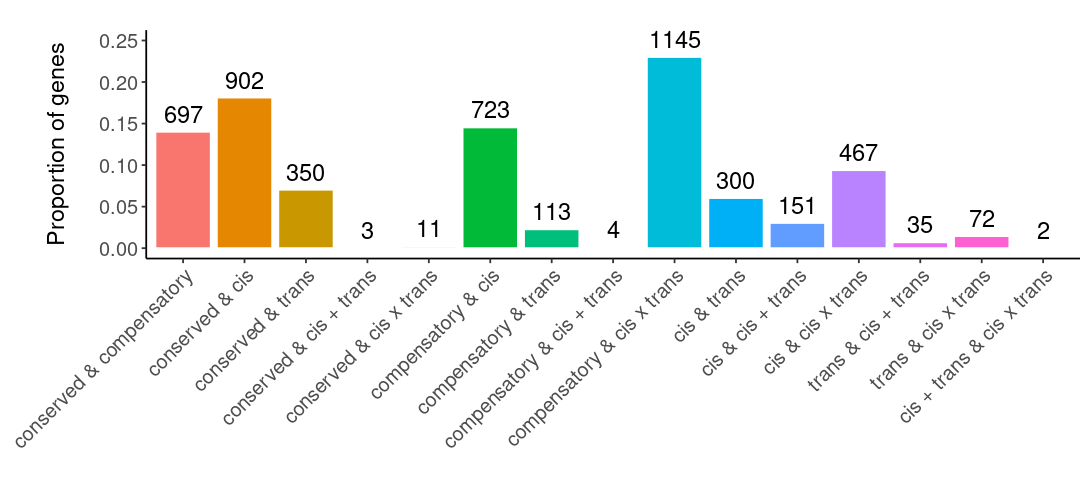

In [125]:
options(repr.plot.width=9, repr.plot.height=4)

reg_change.matrix.two_classes %>% group_by(classes) %>% tally() %>% arrange(desc(n)) %>%
    mutate("prop"=n/sum(n)) %>% mutate(lab.ypos = cumsum(prop) - 0.1*prop) %>%
    mutate(classes=fct_relevel(classes,
        "conserved & compensatory","conserved & cis","conserved & trans","conserved & cis + trans","conserved & cis x trans",
        "compensatory & cis","compensatory & trans","compensatory & cis + trans","compensatory & cis x trans",
        "cis & trans", "cis & cis + trans","cis & cis x trans","trans & cis + trans","trans & cis x trans",
        "cis + trans & cis x trans")) %>%
    ggplot( aes(x=classes, y=prop, fill=classes)) + 
        geom_bar(stat="identity", color="white") + 
        #scale_fill_manual(values=c(cons="khaki",comp="#E89747",cis="#DB4F4F",trans="#0F96DE",
        #                       'cisXtrans'="#74B089",'cis+trans'="#D19CD3")) +
        labs(title="", y="Proportion of genes\n",x="") + coord_cartesian(ylim=c(0,0.25)) +
        theme_classic() + theme(plot.margin = margin(0, 0, 0, 1, "cm")) +
        theme(axis.text.x=element_text(size=12, angle=45, hjust=1), axis.text.y=element_text(size=12),
              axis.title=element_text(size=14)) + 
        geom_text(aes(label=n), hjust=0.5, vjust=-0.5, size=5, color="black") +
        theme(legend.position="none")

file_name=paste0(plot_path,"out_mmdiff.all_subregions.regulation.two_classs.histogram.posterior",thresh,".pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=9, height=4)
}

In [127]:
reg_change.matrix.three_classes <- mmdiff.comp %>% spread(tissue,reg_class_postprob) %>% na_if(., "unassigned") %>%
    anti_join(pseudogenes,by="feature_id") %>%
    mutate("no_classes"=apply(select(.,-feature_id), 1, function(x) n_distinct(unlist(x),na.rm = T))) %>%
    filter(no_classes==3) %>% select(-no_classes) %>% replace(., is.na(.), "unassigned") %>%
    mutate("classes"=case_when(
        rowSums(.=="conserved") > 0 & rowSums(.=="compensatory") > 0 & rowSums(.=="cis") > 0 ~ "cons_comp_cis",
        rowSums(.=="conserved") > 0 & rowSums(.=="compensatory") > 0 & rowSums(.=="trans") > 0 ~ "cons_comp_trans",
        rowSums(.=="conserved") > 0 & rowSums(.=="compensatory") > 0 & rowSums(.=="cis + trans") > 0 ~ "cons_comp_cis+trans",
        rowSums(.=="conserved") > 0 & rowSums(.=="compensatory") > 0 & rowSums(.=="cis x trans") > 0 ~ "cons_comp_cisXtrans",        
        rowSums(.=="conserved") > 0 & rowSums(.=="cis") > 0 & rowSums(.=="trans") > 0 ~ "cons_cis_trans",
        rowSums(.=="conserved") > 0 & rowSums(.=="cis") > 0 & rowSums(.=="cis + trans") > 0 ~ "cons_cis_cis+trans",
        rowSums(.=="conserved") > 0 & rowSums(.=="cis") > 0 & rowSums(.=="cis x trans") > 0 ~ "cons_cis_cisXtrans",
        rowSums(.=="conserved") > 0 & rowSums(.=="trans") > 0 & rowSums(.=="cis + trans") > 0 ~ "cons_trans_cis+trans",
        rowSums(.=="conserved") > 0 & rowSums(.=="trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "cons_trans_cisXtrans",
        rowSums(.=="conserved") > 0 & rowSums(.=="cis + trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "cons_cis+trans_cisXtrans",
        rowSums(.=="compensatory") > 0 & rowSums(.=="cis") > 0 & rowSums(.=="trans") > 0 ~ "comp_cis_trans",
        rowSums(.=="compensatory") > 0 & rowSums(.=="cis") > 0 & rowSums(.=="cis + trans") > 0 ~ "comp_cis_cis+trans",
        rowSums(.=="compensatory") > 0 & rowSums(.=="cis") > 0 & rowSums(.=="cis x trans") > 0 ~ "comp_cis_cisXtrans",
        rowSums(.=="compensatory") > 0 & rowSums(.=="trans") > 0 & rowSums(.=="cis + trans") > 0 ~ "comp_trans_cis+trans",
        rowSums(.=="compensatory") > 0 & rowSums(.=="trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "comp_trans_cisXtrans",
        rowSums(.=="compensatory") > 0 & rowSums(.=="cis + trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "comp_cis+trans_cisXtrans",
        rowSums(.=="cis") > 0 & rowSums(.=="trans") > 0 & rowSums(.=="cis + trans") > 0 ~ "cis_trans_cis+trans",
        rowSums(.=="cis") > 0 & rowSums(.=="trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "cis_trans_cisXtrans",
        rowSums(.=="cis") > 0 & rowSums(.=="cis + trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "cis_cis+trans_cisXtrans",
        rowSums(.=="trans") > 0 & rowSums(.=="cis + trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "trans_cis+trans_cisXtrans"))                     

In [128]:
reg_change.matrix.three_classes %>% group_by(classes) %>% tally() %>% arrange(desc(n)) %>%
    mutate("proportion"=round(n/sum(n),3))

classes,n,proportion
cons_comp_cis,297,0.254
cons_cis_trans,254,0.217
comp_cis_cisXtrans,251,0.214
cons_comp_trans,84,0.072
comp_trans_cisXtrans,61,0.052
comp_cis_trans,56,0.048
cons_comp_cisXtrans,50,0.043
cis_trans_cis+trans,38,0.032
cis_trans_cisXtrans,24,0.020
cons_cis_cis+trans,11,0.009


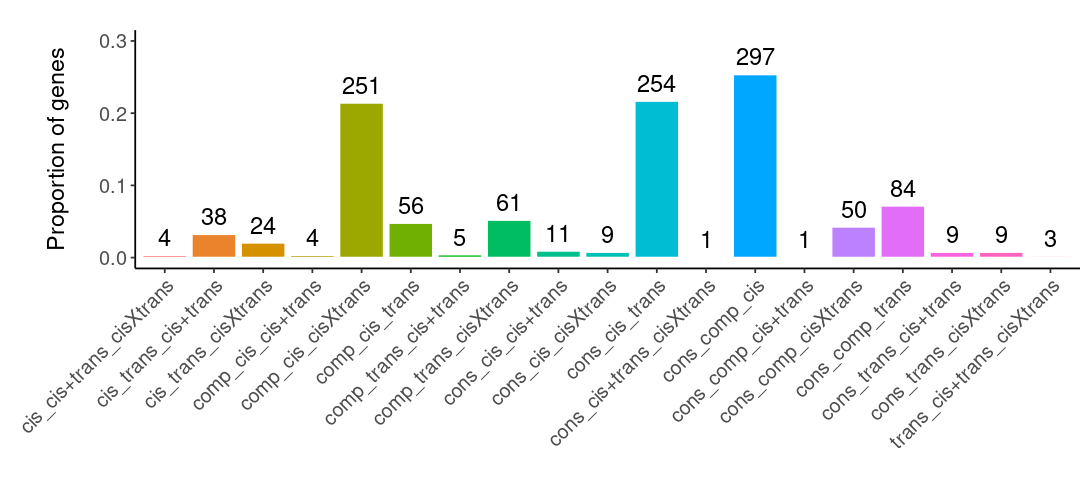

In [129]:
options(repr.plot.width=9, repr.plot.height=4)

reg_change.matrix.three_classes %>% group_by(classes) %>% tally() %>% arrange(desc(n)) %>%
    mutate("prop"=n/sum(n)) %>% mutate(lab.ypos = cumsum(prop) - 0.1*prop) %>%
    #mutate(classes=fct_relevel(classes,
    #    "conserved & compensatory","conserved & cis","conserved & trans","conserved & cis + trans","conserved & cis x trans",
    #    "compensatory & cis","compensatory & trans","compensatory & cis + trans","compensatory & cis x trans",
    #    "cis & trans", "cis & cis + trans","cis & cis x trans","trans & cis + trans","trans & cis x trans",
    #    "cis + trans & cis x trans")) %>%
    ggplot( aes(x=classes, y=prop, fill=classes)) + 
        geom_bar(stat="identity", color="white") + 
        #scale_fill_manual(values=c(cons="khaki",comp="#E89747",cis="#DB4F4F",trans="#0F96DE",
        #                       'cisXtrans'="#74B089",'cis+trans'="#D19CD3")) +
        labs(title="", y="Proportion of genes\n",x="") + coord_cartesian(ylim=c(0,0.3)) +
        theme_classic() + theme(plot.margin = margin(0, 0, 0, 1, "cm")) +
        theme(axis.text.x=element_text(size=12, angle=45, hjust=1), axis.text.y=element_text(size=12),
              axis.title=element_text(size=14)) + 
        geom_text(aes(label=n), hjust=0.5, vjust=-0.5, size=5, color="black") +
        theme(legend.position="none")

file_name=paste0(plot_path,"out_mmdiff.all_subregions.regulation.three_classs.histogram.posterior",thresh,".pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=9, height=4)
}

In [130]:
reg_change.matrix.four_classes <- mmdiff.comp %>% spread(tissue,reg_class_postprob) %>% na_if(., "unassigned") %>%
    anti_join(pseudogenes,by="feature_id") %>%
    mutate("no_classes"=apply(select(.,-feature_id), 1, function(x) n_distinct(unlist(x),na.rm = T))) %>%
    filter(no_classes==4) %>% select(-no_classes) %>% replace(., is.na(.), "unassigned") %>%
    mutate("classes"=case_when(
        rowSums(.=="conserved") > 0 & rowSums(.=="compensatory") > 0 & rowSums(.=="cis") > 0 & rowSums(.=="trans") > 0 ~ "cons_comp_cis_trans",
        rowSums(.=="conserved") > 0 & rowSums(.=="compensatory") > 0 & rowSums(.=="cis") > 0 & rowSums(.=="cis + trans") > 0 ~ "cons_comp_cis_cis+trans",
        rowSums(.=="conserved") > 0 & rowSums(.=="compensatory") > 0 & rowSums(.=="cis") > 0 & rowSums(.=="cis x trans") > 0~ "cons_comp_cis_cisXtrans",      
        rowSums(.=="conserved") > 0 & rowSums(.=="compensatory") > 0 & rowSums(.=="trans") > 0 & rowSums(.=="cis + trans") > 0 ~ "cons_comp_trans_cis+trans",
        rowSums(.=="conserved") > 0 & rowSums(.=="compensatory") > 0 & rowSums(.=="trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "cons_comp_trans_cisXtrans",        
        rowSums(.=="conserved") > 0 & rowSums(.=="compensatory") > 0 & rowSums(.=="cis + trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "cons_comp_cis+trans_cisXtrans",        
        rowSums(.=="conserved") > 0 & rowSums(.=="cis") > 0 & rowSums(.=="trans") > 0 & rowSums(.=="cis + trans") > 0 ~ "cons_cis_trans_cis+trans",
        rowSums(.=="conserved") > 0 & rowSums(.=="cis") > 0 & rowSums(.=="trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "cons_cis_trans_cisXtrans",
        rowSums(.=="conserved") > 0 & rowSums(.=="cis") > 0 & rowSums(.=="cis + trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "cons_cis_cis+trans_cisXtrans",
        rowSums(.=="conserved") > 0 & rowSums(.=="trans") > 0 & rowSums(.=="cis + trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "cons_trans_cis+trans_cisXtrans",
        rowSums(.=="compensatory") > 0 & rowSums(.=="cis") > 0 & rowSums(.=="trans") > 0 & rowSums(.=="cis + trans") > 0 ~ "comp_cis_trans_cis+trans",
        rowSums(.=="compensatory") > 0 & rowSums(.=="cis") > 0 & rowSums(.=="trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "comp_cis_trans_cisXtrans",
        rowSums(.=="compensatory") > 0 & rowSums(.=="cis") > 0 & rowSums(.=="cis + trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "comp_cis_cis+trans_cisXtrans",
        rowSums(.=="compensatory") > 0 & rowSums(.=="trans") > 0 & rowSums(.=="cis + trans") > 0 & rowSums(.=="cis x trans") > 0~ "comp_trans_cis+trans_cisXtrans",
        rowSums(.=="cis") > 0 & rowSums(.=="trans") > 0 & rowSums(.=="cis + trans") > 0 & rowSums(.=="cis x trans") > 0 ~ "cis_trans_cis+trans_cisXtrans"))

In [131]:
reg_change.matrix.four_classes %>% group_by(classes) %>% tally() %>% arrange(desc(n))

classes,n
cons_comp_cis_trans,45
cons_comp_cis_cisXtrans,27
cons_cis_trans_cis+trans,11
cons_comp_trans_cisXtrans,11
comp_cis_trans_cisXtrans,8
cons_comp_cis_cis+trans,3
comp_cis_trans_cis+trans,2
comp_cis_cis+trans_cisXtrans,1
cons_comp_trans_cis+trans,1


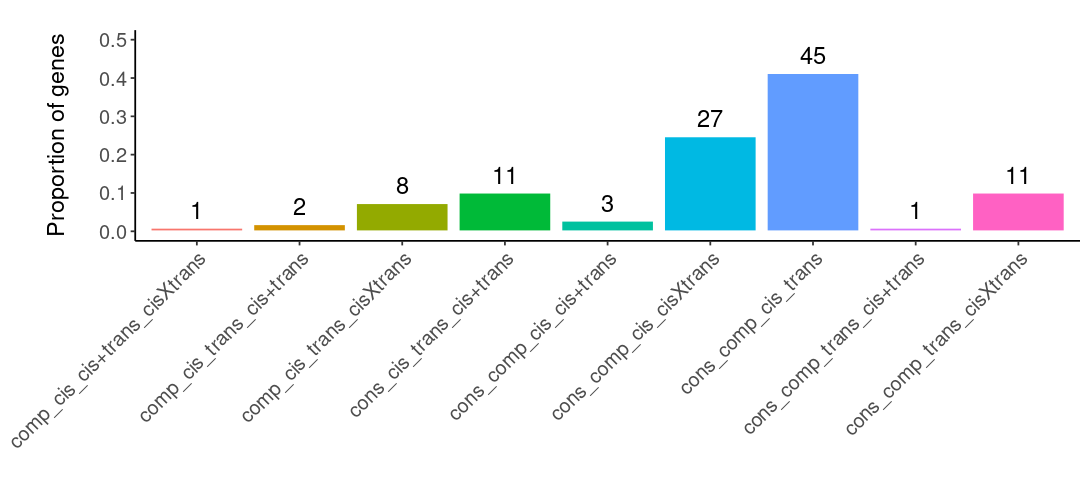

In [132]:
options(repr.plot.width=9, repr.plot.height=4)

reg_change.matrix.four_classes %>% group_by(classes) %>% tally() %>% arrange(desc(n)) %>%
    mutate("prop"=n/sum(n)) %>% mutate(lab.ypos = cumsum(prop) - 0.1*prop) %>%
    #mutate(classes=fct_relevel(classes,
    #    "conserved & compensatory","conserved & cis","conserved & trans","conserved & cis + trans","conserved & cis x trans",
    #    "compensatory & cis","compensatory & trans","compensatory & cis + trans","compensatory & cis x trans",
    #    "cis & trans", "cis & cis + trans","cis & cis x trans","trans & cis + trans","trans & cis x trans",
    #    "cis + trans & cis x trans")) %>%
    ggplot( aes(x=classes, y=prop, fill=classes)) + 
        geom_bar(stat="identity", color="white") + 
        #scale_fill_manual(values=c(cons="khaki",comp="#E89747",cis="#DB4F4F",trans="#0F96DE",
        #                       'cisXtrans'="#74B089",'cis+trans'="#D19CD3")) +
        labs(title="", y="Proportion of genes\n",x="") + coord_cartesian(ylim=c(0,0.5)) +
        theme_classic() + theme(plot.margin = margin(0, 0, 0, 1, "cm")) +
        theme(axis.text.x=element_text(size=12, angle=45, hjust=1), axis.text.y=element_text(size=12),
              axis.title=element_text(size=14)) + 
        geom_text(aes(label=n), hjust=0.5, vjust=-0.5, size=5, color="black") +
        theme(legend.position="none")

file_name=paste0(plot_path,"out_mmdiff.all_subregions.regulation.four_classs.histogram.posterior",thresh,".pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=9, height=4)
}

In [133]:
reg_change.matrix.five_classes <- mmdiff.comp %>% spread(tissue,reg_class_postprob) %>% na_if(., "unassigned") %>%
    anti_join(pseudogenes,by="feature_id") %>%
    mutate("no_classes"=apply(select(.,-feature_id), 1, function(x) n_distinct(unlist(x),na.rm = T))) %>%
    filter(no_classes==5) %>% select(-no_classes) %>% replace(., is.na(.), "unassigned") 
reg_change.matrix.five_classes

feature_id,amygdala,cerebellum,cortex,hindbrain,hippocampus,hypothalamus,midbrain,septum,striatum,thalamus
Brinp3,unassigned,unassigned,trans,conserved,cis,compensatory,unassigned,unassigned,cis x trans,compensatory
Dgkq,unassigned,cis + trans,conserved,unassigned,cis,unassigned,compensatory,unassigned,trans,unassigned
Lifr,conserved,trans,cis,cis x trans,compensatory,unassigned,trans,unassigned,unassigned,unassigned
Olfml2b,unassigned,cis x trans,trans,cis,cis + trans,conserved,cis,unassigned,cis,cis
Spon1,unassigned,unassigned,trans,compensatory,cis x trans,cis,compensatory,unassigned,conserved,trans
Whrn,unassigned,conserved,cis,compensatory,cis x trans,unassigned,trans,unassigned,unassigned,unassigned


### Heatmap inter-region change

In [141]:
classchange="conscis"

reg_change.matrix <- mmdiff.comp %>% 
    anti_join(pseudogenes,by="feature_id") %>%
    spread(tissue,reg_class_postprob) %>% na_if(., "unassigned") %>%
    mutate("no_classes"=apply(select(.,-feature_id), 1, function(x) n_distinct(unlist(x),na.rm = T))) %>%
    filter(no_classes>=2) %>% replace(., is.na(.), "unassigned") %>%
    mutate("fg"=if_else((rowSums(.=="cis") >= 1) & 
                        (rowSums(.=="conserved") >= 1) & (rowSums(.=="compensatory") == 0) &
                        (rowSums(.=="trans") == 0) &
                        (rowSums(.=="cis x trans") == 0) & (rowSums(.=="cis + trans") == 0), "1", "0"))
                              
reg_change.matrix %>% group_by(fg) %>% tally()

fg,n
0,5359
1,902


In [143]:
# Following: https://towardsdatascience.com/hierarchical-clustering-on-categorical-data-in-r-a27e578f2995

# cluster SUBREGIONS based on gower distance
# create distance matrix
gower_dist.subregion <- reg_change.matrix %>% filter(fg==1) %>% select(-no_classes,-fg,-feature_id) %>% 
    mutate_all(as.factor) %>% t() %>% as.data.frame() %>% 
    na_if(., "unassigned") %>% 
    daisy(., metric="gower", stand=T, warnType=F)

# divisive clustering
div_clust.subregion <- diana(as.matrix(gower_dist.subregion), diss=T, keep.diss=F)
div_clust.subregion.list <- div_clust.subregion$order.lab

# agglomerative clustering
aggl_clust_c.subregion <- hclust(gower_dist.subregion, method="complete")
aggl_clust_c.subregion.order <- aggl_clust_c.subregion$order %>% as.character() %>% as.data.frame() %>% 
    set_names("order")
aggl_clust_c.subregion.list <- cbind("order"=seq(1,10), "subregion"=aggl_clust_c.subregion$labels) %>% as.data.frame() %>% 
    right_join(aggl_clust_c.subregion.order , by="order") %>% select(subregion) %>% unlist() %>% as.vector()

In [144]:
# cluster GENES based on gower distance
# create distance matrix
gower_dist.gene <- reg_change.matrix %>% filter(fg==1) %>% select(-no_classes,-fg) %>% mutate_all(as.factor) %>% 
    column_to_rownames("feature_id") %>% as.data.frame() %>% 
    daisy(., metric="gower", stand=T, warnType=F)

# divisive clustering
div_clust.gene <- diana(as.matrix(gower_dist.gene), diss=T, keep.diss=F)
div_clust.gene.list <- div_clust.gene$order.lab

# agglomerative clustering
aggl_clust_c.gene <- hclust(gower_dist.gene, method="complete")
aggl_clust_c.gene.order <- aggl_clust_c.gene$order %>% as.character() %>% as.data.frame() %>% set_names("order")
aggl_clust_c.gene.list <- cbind("order"=seq(1,nrow(aggl_clust_c.gene.order)), "feature_id"=aggl_clust_c.gene$labels) %>%
    as.data.frame() %>% right_join(aggl_clust_c.gene.order , by="order") %>% select(feature_id) %>% unlist() %>% as.vector()

In [145]:
# plot just the clustering
options(repr.plot.width=10, repr.plot.height=7)

file_name=paste0(plot_path,"out_mmdiff.all_subregions.regulation.reg_change.",classchange,".hclust.posterior",thresh,".pdf")
if(!file.exists(file_name)) {
    pdf(file_name,width=10,height=7)
    plot(div_clust.subregion, main="Divisive, subregions")
    #plot(div_clust.gene, main="Divisive, genes")
    dev.off()
}

png 
  2

Warning message:
“Unknown levels in `f`: compensatory, trans, cis + trans, cis x trans”

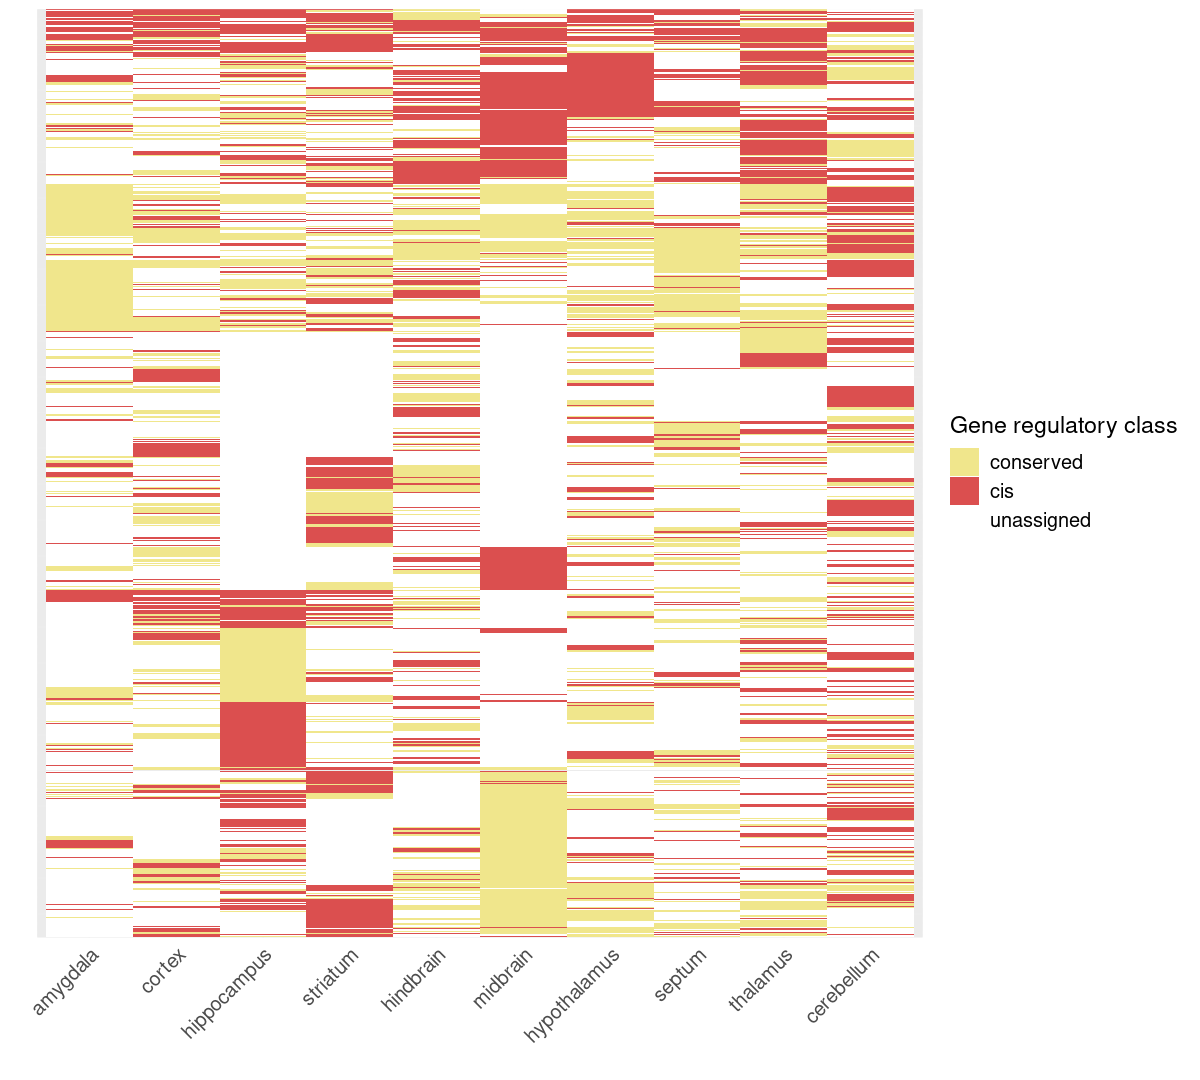

In [146]:
options(repr.plot.width=10, repr.plot.height=9)

sort="gower_div"

reg_change.matrix %>% filter(fg==1) %>% 
    mutate(no_unassigned=rowSums(.=="unassigned"), no_cis=rowSums(.=="cis"), no_trans=rowSums(.=="trans")) %>% 
    arrange(no_cis,desc(no_unassigned)) %>%
    mutate(feature_id=factor(feature_id,levels=unique(feature_id))) %>%
    gather(tissue,class,amygdala:thalamus) %>% 
    mutate(class=fct_relevel(class,"conserved","compensatory","cis","trans",
                                              "cis + trans","cis x trans","unassigned")) %>%
    #mutate(tissue=fct_relevel(tissue,aggl_clust_c.subregion.list)) %>%
    #mutate(gene=fct_relevel(feature_id,rev(aggl_clust_c.gene.list))) %>%
    mutate(tissue=fct_relevel(tissue,div_clust.subregion.list)) %>%
    mutate(gene=fct_relevel(feature_id,rev(div_clust.gene.list))) %>%
    #mutate(tissue=fct_relevel(tissue,sorted.subregion.list)) %>%
    ggplot( aes(tissue,gene)) + geom_tile(aes(fill=class)) + 
        scale_fill_manual(values=c(conserved="khaki",compensatory="#E89747",cis="#DB4F4F",trans="#0F96DE",
                                   'cis x trans'="#74B089",'cis + trans'="#D19CD3",unassigned="white")) +
        theme_minimal() + theme(axis.text.x=element_text(angle=45,vjust=1,size=12,hjust=1)) + labs(x="",y="") +
        theme(axis.text.y=element_blank()) +
        labs(fill="Gene regulatory class") + 
        theme(legend.title=element_text(size=14), legend.text=element_text(size=12))

file_name=paste0(plot_path,"out_mmdiff.all_subregions.regulation.reg_change.",classchange,".",sort,".heatmap.posterior",thresh,".pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=10, height=9)
}                                                                                      